<p style="font-family: Cambria; font-size:2.5em;color:Black;"> SVM Models for Multiclass and Multilabel Classification in Sentiment Analysis of Autonomous Vehicle Tweets</p>

>**The aim of this notebook is to compare the performance of multiclass and multilabel classification in order to choose the more accurate classification type.**

# Method

To ensure a fair comparison between the selected models, the manually labeled dataset was split into training, validation, and test subsets. Hyperparameters were then rigorously selected using the validation dataset. Finally, the models were evaluated using the test dataset and a 5 fold cross-validation.

For the SVM model, a Bayesian optimization method was employed using the Optuna library. Bayesian optimization is favored over grid search for hyperparameter tuning in SVM models because it efficiently explores the hyperparameter space by leveraging past evaluation results to inform future trials. This approach leads to faster convergence on optimal parameters with fewer evaluations. The text length and vocabulary limits were defined following a descriptive analysis. The other parameters were selected to accommodate the challenges posed by the small sample size of the data.


## Hardware and Software Environment

The system utilizes TensorFlow 2.13.0 with XLA (Accelerated Linear Algebra) compilation enabled, supporting both FP32 and FP16 precision operations. The NVIDIA L4 GPU (24GB GDDR6), based on the Ada Lovelace architecture, provides hardware support for tensor operations with compute capability 8.9.

The experiments were conducted with the following specifications:

Computing Hardware:
- GPU: NVIDIA L4 (Ada Lovelace architecture) with 24GB GDDR6 memory
- CPU: AMD EPYC 9454 48-Core Processor
- System Memory: 346GB RAM
- GPU Driver Version: 550.90.07
- CUDA Version: 12.4

Software Stack:
- Operating System: Linux 5.15.0-122-generic
- TensorFlow: Version 2.13.0
- Python: Version 3.9.21
- GCC Compiler: Version 11.3.0
- NVIDIA CUDA Runtime: Version 12.4

GPU Performance Metrics:
- Maximum Power Capacity: 72W
- Available GPU Memory: 23,034 MiB
- Memory Utilization: Dynamic allocation up to 20,979 MiB during experiments

System Configuration:
- CPU Architecture: x86_64 with 90 available cores
- L3 Cache: 1.4 GiB
- CPU Features: Support for AVX-512, FMA, and other advanced instruction sets
- Virtualization: Full AMD-V virtualization under KVM hypervisor


# Label Mapping

**Multiclass Classification**

  Column name: 'Label_B_emotion'<br>
  0: Positive<br>
  1: Negative<br>
  2: Neutral or informative<br>

**Multilabel Classification**

Column names: 'Label_A1_positive', 'Label_A2_negative', 'Label_A3_neutral'

Sentiment label mapping:<br>
- 0 = absence of sentiment,<br>
- 1 = presence of sentiment

# Installing necessary libraries

**Install PyTorch (CUDA-enabled version for GPU support)** <br>
`conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch`

**Install NumPy for numerical operations** <br>
`pip install numpy==1.24.3`

**Install scikit-learn for machine learning functions** <br>
`conda install scikit-learn`

**Install pandas for data manipulation** <br>
`conda install pandas`

**Install matplotlib for plotting** <br>
`conda install matplotlib`

**Install seaborn for enhanced visualization** <br>
`conda install seaborn`

# Import libraries

In [1]:
import sys
print('The current notebook is using Python version 3.9.')
print(sys.version)

The current notebook is using Python version 3.9.
3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]


In [2]:
import torch
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.1


In [3]:
# =============================================================================
# Standard Library Imports
# =============================================================================
import os          # Operating system interface
import json        # JSON encoder and decoder
import traceback   # Stack trace management
import warnings    # Warning control
from collections import Counter     # Counting hashable objects
from typing import Any             # Type hinting support

# =============================================================================
# Core Scientific Computing
# =============================================================================
import numpy as np          # Numerical computing and array operations
import pandas as pd         # Data manipulation and analysis
import scipy.sparse        # Sparse matrix operations
import scipy.stats as stats # Statistical functions
import scipy.sparse        # Sparse matrix operations

# =============================================================================
# Deep Learning Framework
# =============================================================================
import torch               # PyTorch deep learning library

# =============================================================================
# Hyperparameter Optimization
# =============================================================================
import optuna              # Hyperparameter optimization framework
from optuna.trial import Trial     # Trial object for optimization
from optuna.samplers import TPESampler  # Tree-structured Parzen Estimator sampling
from optuna.pruners import MedianPruner # Pruning method for optimization

# =============================================================================
# Machine Learning (scikit-learn)
# =============================================================================
# Base Utilities
from sklearn.base import clone    # Deep copy of estimators

# Feature Processing
from sklearn.feature_extraction.text import (
    TfidfVectorizer,         # TF-IDF feature extraction
    CountVectorizer          # Bag-of-words feature extraction
)
from sklearn.preprocessing import (
    StandardScaler,          # Feature standardization
    MinMaxScaler,           # Feature normalization
    LabelEncoder,           # Label encoding
    LabelBinarizer         # Label binarization
)
from sklearn.svm import SVC # Support Vector Classification
from sklearn.ensemble import VotingClassifier  # Voting Classifier
from sklearn.preprocessing import label_binarize # Convert labels to binary matrix

# Model Selection
from sklearn.model_selection import (
    train_test_split,        # Dataset splitting
    KFold,                   # K-Folds cross-validator
    StratifiedKFold,         # Stratified K-Folds
    GridSearchCV,            # Parameter search
    cross_val_score         # Cross-validation scoring
)

# Models
from sklearn.svm import (
    SVC,                     # Support Vector Classification
    LinearSVC               # Linear Support Vector Classification
)
from sklearn.ensemble import (
    RandomForestClassifier,  # Random Forest
    GradientBoostingClassifier,  # Gradient Boosting
    VotingClassifier        # Voting Classifier
)

# Metrics and Evaluation
from sklearn.metrics import (
    accuracy_score,          # Classification accuracy
    classification_report,   # Detailed classification metrics
    confusion_matrix,        # Confusion matrix
    f1_score,               # F1 score
    precision_score,        # Precision
    recall_score,           # Recall
    precision_recall_fscore_support,  # Combined metrics
    auc,                    # Calculate Area Under Curve
    cohen_kappa_score,      # Calculate cohen_kappa_score
    roc_auc_score,          # ROC AUC score
    roc_curve,              # ROC curve
    precision_recall_curve,  # Precision-Recall curve
    jaccard_score
)

# Pipeline and Base Classes
from sklearn.pipeline import Pipeline, make_pipeline  # Pipeline construction
from sklearn.base import BaseEstimator, TransformerMixin  # Base classes
from sklearn.calibration import CalibratedClassifierCV    # Probability calibration

# =============================================================================
# Visualization
# =============================================================================
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns           # Statistical visualization

# Visualization Settings
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid", {'axes.grid': False})
sns.set_palette("tab20")

# Font Sizes Configuration
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 12, 13, 14
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE, 
       labelweight='normal', labelcolor='black', labelpad=5, titlepad=10)
plt.rc('xtick', labelsize=MEDIUM_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=MEDIUM_SIZE, labelsize=BIGGER_SIZE)

# =============================================================================
# Jupyter/IPython Display
# =============================================================================
from IPython.display import display, HTML

# Suppress warnings
warnings.filterwarnings('ignore')

In [4]:
# --- Identifying and Specifying the GPU Device ---

# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")

# Check GPU properties
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

CUDA available: True
CUDA version: 12.4
PyTorch version: 2.5.1
GPU Device: NVIDIA L4
GPU Memory: 21.95 GB


# Data opening

In [5]:
# Read all datasets
trainDf = pd.read_csv('/workspace/train60_data_mapped.csv', sep=";") #60% of the labeled tweets
valDf = pd.read_csv('/workspace/val20_data_mapped.csv', sep=";")     #20% of the labeled tweets
testDf = pd.read_csv('/workspace/test20_data_mapped.csv', sep=";")   #20% of the labeled tweets

# Concatenate all dataframes
df = pd.concat([trainDf, valDf, testDf], axis=0, ignore_index=True)

# sample for rush the code development
#trainDf = trainDf.head(60)
#valDf = valDf.head(20)
#testDf = testDf.head(20)

# Display information about the combined dataset
print("\nCombined Dataset Info:")
print("Shape:", df.shape)

# Display basic information about each dataset
print("\nTraining Dataset Info:")
print("Shape:", trainDf.shape)

print("\nValidation Dataset Info:")
print("Shape:", valDf.shape)

print("\nTest Dataset Info:")
print("Shape:", testDf.shape)


Combined Dataset Info:
Shape: (1198, 7)

Training Dataset Info:
Shape: (718, 7)

Validation Dataset Info:
Shape: (240, 7)

Test Dataset Info:
Shape: (240, 7)


# SVM model - Multiclass classification

## Multiclass & text: preparing training, validation and testing datasets

In [6]:
# Extracting features (text) and labels from training DataFrame
X_train = trainDf['text'].tolist()
y_train = trainDf['Label_B_emotion'].tolist()
"""
Training Data (60%):
Features (X_train) and labels (y_train) extracted from the training dataset for model development.
"""

# Extracting features (text) and labels from validation DataFrame
X_val = valDf['text'].tolist()
y_val = valDf['Label_B_emotion'].tolist()
"""
Validation Data (20%):
Features (X_val) and labels (y_val) extracted from the validation dataset for model optimization.
"""

# Extracting features (text) and labels from test DataFrame
X_test = testDf['text'].tolist()
y_test = testDf['Label_B_emotion'].tolist()
"""
Test Data (20%):
Features (X_test) and labels (y_test) extracted from the test dataset for final performance evaluation.
"""

'\nTest Data (20%):\nFeatures (X_test) and labels (y_test) extracted from the test dataset for final performance evaluation.\n'

## Metric definitions for multiclass classification

In [7]:
# ----------------------- Metric 2, Global Accuracy and F1 score function -----------------------
def metric2_MC(y_true, y_pred):
    """
    Implementation of Metric 2 following the formula:
    1 - (1/M)∑(j=1 to M)[(∑(i=1 to N) 𝟙(|y_true_{i,j} - round(y_pred_{i,j})| = 1))/N]
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        Ground truth labels
    y_pred : array-like of shape (n_samples,)
        Predicted labels
        
    Returns:
    float : The computed metric value
    """
    # Convert inputs to numpy arrays if they aren't already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Ensure the predictions are rounded to nearest integer
    y_pred_rounded = np.round(y_pred)
    
    # Calculate absolute differences
    differences = np.abs(y_true - y_pred_rounded)
    
    # Convert to one-hot encoding for multi-class case
    n_classes = len(np.unique(y_true))
    y_true_one_hot = np.eye(n_classes)[y_true]
    
    # Count predictions off by 1 for each class
    off_by_one_per_class = []
    for j in range(n_classes):
        class_mask = (y_true == j)
        if np.sum(class_mask) > 0:  # Avoid division by zero
            off_by_one = np.sum((differences == 1) & class_mask)
            proportion = off_by_one / np.sum(class_mask)
            off_by_one_per_class.append(proportion)
    
    # Calculate final metric
    metric = 1 - np.mean(off_by_one_per_class)
    return metric

def macro_f1(y_true, y_pred):
    """
    Compute the macro F1 score for multi-class classification.
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        Ground truth labels
    y_pred : array-like of shape (n_samples,)
        Predicted labels
        
    Returns:
    float : Macro-averaged F1 score
    """
    from sklearn.metrics import f1_score
    return f1_score(y_true, y_pred, average='macro')

def weighted_f1(y_true, y_pred):
    """
    Compute the weighted F1 score for multi-class classification.
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        Ground truth labels
    y_pred : array-like of shape (n_samples,)
        Predicted labels
        
    Returns:
    float : Weighted F1 score
    """
    from sklearn.metrics import f1_score
    return f1_score(y_true, y_pred, average='weighted')
    
def global_accuracy(y_true, y_pred):
    """
    Implementation of Global Accuracy following the formula:
    (1/3n)∑(i=0 to n)∑(j=1 to 3) 𝟙(u_{i,j}=v_{i,j})
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        Ground truth labels
    y_pred : array-like of shape (n_samples,)
        Predicted labels
        
    Returns:
    float : Global accuracy score
    """
    # Convert inputs to numpy arrays if they aren't already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # For multi-class classification, this is equivalent to standard accuracy
    return np.mean(y_true == y_pred)

def MC_weighted_accuracy(y_true, y_pred):
    """
    Calculate weighted accuracy for multiclass classification, where the weight
    of each class is inversely proportional to its frequency in the dataset.
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        Ground truth labels
    y_pred : array-like of shape (n_samples,)
        Predicted labels
        
    Returns:
    float : Weighted accuracy score
    """
    # Convert to numpy arrays if they aren't already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Get unique classes
    classes = np.unique(y_true)
    n_classes = len(classes)
    
    class_accuracies = []
    weights = []
    
    for c in classes:
        # Get samples belonging to this class
        class_mask = (y_true == c)
        n_samples_class = np.sum(class_mask)
        
        if n_samples_class == 0:
            continue
            
        # Calculate weight as inverse of class frequency
        weight = len(y_true) / (n_classes * n_samples_class)
        
        # Calculate accuracy for this class
        class_accuracy = np.sum((y_true == c) & (y_pred == c)) / n_samples_class
        
        class_accuracies.append(class_accuracy)
        weights.append(weight)
    
    # Normalize weights to sum to 1
    weights = np.array(weights)
    weights = weights / np.sum(weights)
    
    return np.sum(np.array(class_accuracies) * weights)

## Optuna Params Search for Multiclass Classification - Baysian Approach

**Method for Selecting the Best Model**

A custum score (balanced score) was calculated using the following distribution of weights:
- Weighted_f1: 40% weight on F1 score
- Normalized Loss: 30% weight on loss
- Cross-Validation Stability: 30% weight.

The `calculate_balanced_score` function computes a score ranging from 0 to 1. A value closer to 1 indicates better model performance.

In [18]:
# ===========================================================================================================
#                              Optuna Hyperparameters Search for SVM
#                     Full Deterministisc Approach to Ensure Reproductibility
#                                   Multiclass classification
# ===========================================================================================================


# Configuration dictionary for all parameters
CONFIG = {
    'tfidf': {
        'ngram_range': [(1, 1), (1, 2), (1, 3)],
        'max_features': [2500, 3000, 3500]
    },
    'svm': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'degree': [3, 4, 5],
        'decision_function_shape': 'ovr',
        'max_iter': 3000,
        'tol': 0.01,
        'verbose': False,
        'n_labels': 3
    }
}

class BalancedScorer:
    def __init__(self, X_train):
        self.X_train = X_train
    
    def __call__(self, estimator, X, y_true):
        """
        Custom scorer that combines F1, loss, and CV stability
        """
        y_pred = estimator.predict(X)
        weighted_f1 = f1_score(y_true, y_pred, average='weighted')
        
        try:
            y_prob = estimator.predict_proba(X)
            loss = log_loss(y_true, y_prob)
        except:
            loss = 1.0
        
        cv_stability = 0.8
        max_loss = 5.0
        normalized_loss = 1 - (min(loss, max_loss) / max_loss)
        score = (0.4 * weighted_f1) + (0.3 * normalized_loss) + (0.3 * cv_stability)
        
        return score

def create_model(trial):
    """
    Create a pipeline with parameters suggested by Optuna based on config values
    """
    # Suggest parameters from config values
    ngram_range = CONFIG['tfidf']['ngram_range'][trial.suggest_int('ngram_range_idx', 0, len(CONFIG['tfidf']['ngram_range'])-1)]
    max_features = CONFIG['tfidf']['max_features'][trial.suggest_int('max_features_idx', 0, len(CONFIG['tfidf']['max_features'])-1)]
    C = CONFIG['svm']['C'][trial.suggest_int('C_idx', 0, len(CONFIG['svm']['C'])-1)]
    kernel = trial.suggest_categorical('kernel', CONFIG['svm']['kernel'])
    gamma = CONFIG['svm']['gamma'][trial.suggest_int('gamma_idx', 0, len(CONFIG['svm']['gamma'])-1)]
    degree = CONFIG['svm']['degree'][trial.suggest_int('degree_idx', 0, len(CONFIG['svm']['degree'])-1)]
    
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            ngram_range=ngram_range,
            max_features=max_features
        )),
        ('svm', SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            degree=degree,
            decision_function_shape=CONFIG['svm']['decision_function_shape'],
            max_iter=CONFIG['svm']['max_iter'],
            tol=CONFIG['svm']['tol'],
            verbose=CONFIG['svm']['verbose'],
            random_state=42,
            class_weight=None,
            probability=True
        ))
    ])
    
    return pipeline

def objective(trial):
    pipeline = create_model(trial)
    scorer = BalancedScorer(X_train)
    scores = cross_val_score(
        pipeline, X_train, y_train,
        scoring=scorer,
        cv=5,
        n_jobs=-1
    )
    return scores.mean()

# Calculate search space for GridSampler
search_space = {
    'ngram_range_idx': list(range(len(CONFIG['tfidf']['ngram_range']))),
    'max_features_idx': list(range(len(CONFIG['tfidf']['max_features']))),
    'C_idx': list(range(len(CONFIG['svm']['C']))),
    'kernel': CONFIG['svm']['kernel'],
    'gamma_idx': list(range(len(CONFIG['svm']['gamma']))),
    'degree_idx': list(range(len(CONFIG['svm']['degree'])))
}

# Set up the study with GridSampler
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.GridSampler(search_space)
)

# Calculate total possible combinations
total_combinations = (len(CONFIG['tfidf']['ngram_range']) * 
                     len(CONFIG['tfidf']['max_features']) * 
                     len(CONFIG['svm']['C']) * 
                     len(CONFIG['svm']['kernel']) * 
                     len(CONFIG['svm']['gamma']) * 
                     len(CONFIG['svm']['degree']))

print(f"Total possible combinations: {total_combinations}")

# Set up the study with TPESampler instead of GridSampler
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Using TPE algorithm with fixed seed for reproducibility
)

# Run optimization with 35 trials
n_trials = 35
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

def get_actual_params(trial_params):
    """Helper function to convert indices to actual parameter values"""
    return {
        'tfidf__ngram_range': CONFIG['tfidf']['ngram_range'][trial_params['ngram_range_idx']],
        'tfidf__max_features': CONFIG['tfidf']['max_features'][trial_params['max_features_idx']],
        'svm__C': CONFIG['svm']['C'][trial_params['C_idx']],
        'svm__kernel': trial_params['kernel'],
        'svm__gamma': CONFIG['svm']['gamma'][trial_params['gamma_idx']],
        'svm__degree': CONFIG['svm']['degree'][trial_params['degree_idx']]
    }

# Get best parameters
best_params = get_actual_params(study.best_trial.params)
print("Best parameters:", best_params)
print("Best score:", study.best_value)

# Create and train best model
best_pipeline = create_model(study.best_trial)
best_pipeline.fit(X_train, y_train)

# Evaluate on validation set
scorer = BalancedScorer(X_train)
validation_score = scorer(best_pipeline, X_val, y_val)
print("Validation set score:", validation_score)

# Create results DataFrame from study
study_results = []
for trial in study.trials:
    if trial.state == optuna.trial.TrialState.COMPLETE:
        params = get_actual_params(trial.params)
        study_results.append({
            'params': params,
            'balanced_score': trial.value,
            'rank': len(study_results) + 1
        })

results_df = pd.DataFrame(study_results)
results_df = results_df.sort_values('balanced_score', ascending=False)

# Display results summary
print("\nOptuna Study Results Summary:")
from IPython.display import display
display(results_df)

# Save results
save_dir = '/workspace/Output/SVM/SVM_MC/Optuna_search'
os.makedirs(save_dir, exist_ok=True)

# Save results to CSV
results_df.to_csv(os.path.join(save_dir, 'SVM_multiclass_optuna_results.csv'), 
                  index=False, sep=';')

# Save best parameters as JSON
import json
with open(os.path.join(save_dir, 'SVM_multiclass_optuna_best_params_4_balanced.json'), 'w') as f:
    json.dump(best_params, f, indent=4)

# Save study object
import joblib
joblib.dump(study, os.path.join(save_dir, 'optuna_study_4_balanced.pkl'))

[I 2025-01-11 17:20:10,252] A new study created in memory with name: no-name-df6c0734-55fa-4a07-97e1-dfd46a09545e
[I 2025-01-11 17:20:10,254] A new study created in memory with name: no-name-f6354597-36c8-46a6-b0a3-c8784b82b3dd


Total possible combinations: 1296


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2025-01-11 17:20:10,718] Trial 0 finished with value: 0.6660962730181448 and parameters: {'ngram_range_idx': 1, 'max_features_idx': 2, 'C_idx': 2, 'kernel': 'rbf', 'gamma_idx': 0, 'degree_idx': 2}. Best is trial 0 with value: 0.6660962730181448.
[I 2025-01-11 17:20:11,162] Trial 1 finished with value: 0.5499474907100034 and parameters: {'ngram_range_idx': 1, 'max_features_idx': 2, 'C_idx': 0, 'kernel': 'rbf', 'gamma_idx': 0, 'degree_idx': 0}. Best is trial 0 with value: 0.6660962730181448.
[I 2025-01-11 17:20:11,535] Trial 2 finished with value: 0.6600738694799435 and parameters: {'ngram_range_idx': 0, 'max_features_idx': 1, 'C_idx': 1, 'kernel': 'linear', 'gamma_idx': 1, 'degree_idx': 1}. Best is trial 0 with value: 0.6660962730181448.
[I 2025-01-11 17:20:11,969] Trial 3 finished with value: 0.5499474907100034 and parameters: {'ngram_range_idx': 1, 'max_features_idx': 2, 'C_idx': 0, 'kernel': 'linear', 'gamma_idx': 2, 'degree_idx': 0}. Best is trial 0 with value: 0.6660962730181448

,params,balanced_score,rank
32,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 3500, 'svm__C': 1, 'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__degree': 5}",0.668425,33
33,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 3500, 'svm__C': 1, 'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__degree': 5}",0.668425,34
34,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 3500, 'svm__C': 1, 'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__degree': 5}",0.668425,35
31,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 3500, 'svm__C': 1, 'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__degree': 5}",0.668425,32
30,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 3500, 'svm__C': 1, 'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__degree': 5}",0.668425,31
14,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_features': 2500, 'svm__C': 1, 'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__degree': 5}",0.666386,15
0,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 3500, 'svm__C': 10, 'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__degree': 5}",0.666096,1
23,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 2500, 'svm__C': 1, 'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__degree': 5}",0.666089,24
27,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 2500, 'svm__C': 1, 'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__degree': 5}",0.666089,28
22,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 2500, 'svm__C': 10, 'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__degree': 5}",0.665432,23


['/workspace/Output/SVM/SVM_MC/Optuna_search/optuna_study_4_balanced.pkl']

## Testing processing using Optuna Search Results

## Ensemble Model Learning for Multiclass Classification - testing with the Optuna hyperparameters
This approach involves the following key steps:
- **Data Stratification**:<br>
Utilize StratifiedKFold to ensure balanced class distribution across all folds, maintaining representative data splits.

- **Multiple Model Training**:<br>
Perform 5-fold cross-validation to obtain 5 models trained in different data subsets, following a systematic cross-validation training pipeline.

- **Model Building**:<br>
Instead of selecting a single best model, all 5 models trained are retained, with each training process employing early stopping based on a custom composite metric:
  - 40% Weighted F1 Score
  - 30% Normalized Loss
  - 30% CV Stability

- **Model Averaging**:<br>
For final prediction on the test set:<br>
  - Use each of the 5 fold models to make predictions<br>
  - Implement soft voting by averaging prediction probabilities from all models<br>
  - Generate final ensemble prediction based on highest average probability<br>

- **Evaluation of Ensemble Predictions**:<br>
The ensemble predictions are evaluated on the test set to assess performance, combining the strengths of multiple models through the ensemble learning approach.

Formulas used:

1. Coefficient of Variation (CV):

$$CV = \frac{\text{Standard Deviation}}{\text{mean}}$$

2. Quartile Coefficient of Dispersion (QCD):

$$QCD = \frac{Q3 - Q1}{Q3 + Q1}$$


In [19]:

# ===========================================================================================================
#                SVM - Training, Validation and Testing for Multiclass classification
# ===========================================================================================================

# Metrics functions are previously defined (metric2, gobal_accuracy, weighted F1 etc.) 

# System Information
SYSTEM_CONFIG = {
    'gpu': 'NVIDIA L4',
    'cuda_version': '12.4',
    'pytorch_version': '2.5.1',
    'gpu_memory': '24GB',
    'max_power': '72W'
}

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# GPU settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


# Load Optuna best parameters
OPTUNA_CONFIG_PATH = "/workspace/Output/SVM/SVM_MC/Optuna_search/SVM_multiclass_optuna_best_params_4_balanced.json"

def load_optuna_config():
    with open(OPTUNA_CONFIG_PATH, 'r') as f:
        return json.load(f)

# Load Optuna parameters
optuna_params = load_optuna_config()

# Create CONFIG from Optuna parameters (only using available parameters)
CONFIG = {
    'model_params': {
        # TF-IDF parameters
        'max_features': optuna_params['tfidf__max_features'],
        'ngram_range': tuple(optuna_params['tfidf__ngram_range']),
        
        # SVM parameters
        'C': optuna_params['svm__C'],
        'kernel': optuna_params['svm__kernel'],
        'gamma': optuna_params['svm__gamma'],
        'degree': optuna_params['svm__degree'],
        
        # Runtime parameter
        'random_state': RANDOM_SEED
    },
    'training_params': {
        'n_splits': 5,
        'random_seed': RANDOM_SEED
    },
    'ensemble_params': {
        'voting': 'soft',
        'weights': None
    }
}

print("\n" + "="*50)
print("Configuration:")
print("="*50)
for section, params in CONFIG.items():
    print(f"\n{section}:")
    for param, value in params.items():
        print(f"  {param}: {value}")
print("="*50 + "\n")

def calculate_qcd(scores):
    """Calculate Quality Control Distance (QCD)"""
    return 1.96 * np.std(scores) / np.sqrt(len(scores))

def calculate_cv_percentage(mean, std):
    """Calculate Coefficient of Variation (CV) as percentage"""
    return (std / mean * 100) if mean != 0 else 0

def create_metrics_dataframe(cv_scores):
    """Create a pandas DataFrame with all metrics and statistics"""
    metrics_data = []
    
    for metric, scores in cv_scores.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        cv_pct = calculate_cv_percentage(mean_score, std_score)
        qcd = calculate_qcd(scores)
        
        metrics_data.append({
            'Metric': metric,
            'Mean': mean_score,
            'Std': std_score,
            'CV (%)': cv_pct,
            'QCD': qcd
        })
    
    df_metrics = pd.DataFrame(metrics_data)
    
    metric_order = [
        'macro_accuracy', 'micro_accuracy', 'weighted_accuracy',
        'metric2_MC',
        'macro_precision', 'micro_precision', 'weighted_precision',
        'macro_recall', 'micro_recall', 'weighted_recall',
        'macro_f1', 'micro_f1', 'weighted_f1',
        'loss', 'epoch'
    ]
    
    available_metrics = [m for m in metric_order if m in df_metrics['Metric'].values]
    df_metrics['Metric'] = pd.Categorical(df_metrics['Metric'], categories=available_metrics, ordered=True)
    df_metrics = df_metrics.sort_values('Metric').reset_index(drop=True)
    df_metrics['CV (%)'] = df_metrics['CV (%)'].apply(lambda x: f"{x:.2f}%")
    
    return df_metrics
    
def calculate_balanced_score(weighted_f1, calibration_loss, cv_stability):
    """
    Calculate balanced score using:
    - 40% Weighted F1 Score
    - 30% Calibrated Probability Loss
    - 30% CV Stability
    """
    # Normalize loss (assuming lower is better)
    max_loss = 5.0  # typical max value for log loss
    normalized_loss = 1 - (min(calibration_loss, max_loss) / max_loss)
    
    # Calculate final score
    score = (0.4 * weighted_f1) + (0.3 * normalized_loss) + (0.3 * cv_stability)
    return score


def calculate_cv_stability(cv_scores):
    """
    Calculate CV stability based on the coefficient of variation
    Returns a score between 0 and 1 where 1 is most stable
    """
    cv = np.std(cv_scores) / np.mean(cv_scores) if np.mean(cv_scores) != 0 else 0
    stability = 1 / (1 + cv)
    return stability

def create_metrics_dataframe(cv_scores):
    """Create a pandas DataFrame with all metrics and statistics"""
    metrics_data = []
    
    for metric, scores in cv_scores.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        cv_pct = calculate_cv_percentage(mean_score, std_score)
        qcd = calculate_qcd(scores)
        
        metrics_data.append({
            'Metric': metric,
            'Mean': mean_score,
            'Std': std_score,
            'CV (%)': cv_pct,
            'QCD': qcd
        })
    
    df_metrics = pd.DataFrame(metrics_data)
    
    metric_order = [
        'macro_accuracy', 'micro_accuracy', 'weighted_accuracy',
        'metric2_MC',
        'macro_precision', 'micro_precision', 'weighted_precision',
        'macro_recall', 'micro_recall', 'weighted_recall',
        'macro_f1', 'micro_f1', 'weighted_f1',
        'calibration_loss'
    ]
    
    available_metrics = [m for m in metric_order if m in df_metrics['Metric'].values]
    df_metrics['Metric'] = pd.Categorical(df_metrics['Metric'], categories=available_metrics, ordered=True)
    df_metrics = df_metrics.sort_values('Metric').reset_index(drop=True)
    df_metrics['CV (%)'] = df_metrics['CV (%)'].apply(lambda x: f"{x:.2f}%")
    
    return df_metrics

def create_test_results_df(cv_scores, y_test, y_test_pred, y_test_pred_proba):
    """Create comprehensive test results DataFrame"""
    metrics_data = []
    metrics_mapping = {
        'Accuracy (Macro)': ('macro_accuracy', lambda y_t, y_p: accuracy_score(y_t, y_p)),
        'Accuracy (Micro)': ('micro_accuracy', lambda y_t, y_p: accuracy_score(y_t, y_p)),
        'Accuracy (Weighted)': ('weighted_accuracy', lambda y_t, y_p: accuracy_score(y_t, y_p)),
        'Precision (Macro)': ('macro_precision', lambda y_t, y_p: precision_recall_fscore_support(y_t, y_p, average='macro')[0]),
        'Precision (Micro)': ('micro_precision', lambda y_t, y_p: precision_recall_fscore_support(y_t, y_p, average='micro')[0]),
        'Precision (Weighted)': ('weighted_precision', lambda y_t, y_p: precision_recall_fscore_support(y_t, y_p, average='weighted')[0]),
        'Recall (Macro)': ('macro_recall', lambda y_t, y_p: precision_recall_fscore_support(y_t, y_p, average='macro')[1]),
        'Recall (Micro)': ('micro_recall', lambda y_t, y_p: precision_recall_fscore_support(y_t, y_p, average='micro')[1]),
        'Recall (Weighted)': ('weighted_recall', lambda y_t, y_p: precision_recall_fscore_support(y_t, y_p, average='weighted')[1]),
        'F1-Score (Macro)': ('macro_f1', lambda y_t, y_p: precision_recall_fscore_support(y_t, y_p, average='macro')[2]),
        'F1-Score (Micro)': ('micro_f1', lambda y_t, y_p: precision_recall_fscore_support(y_t, y_p, average='micro')[2]),
        'F1-Score (Weighted)': ('weighted_f1', lambda y_t, y_p: precision_recall_fscore_support(y_t, y_p, average='weighted')[2]),
        'Metric2_MC': ('metric2_MC', lambda y_t, y_p: np.mean(y_p))
    }
    
    for metric_name, (cv_key, metric_func) in metrics_mapping.items():
        ensemble_score = metric_func(y_test, y_test_pred) if 'Metric2_MC' not in metric_name else np.mean(y_test_pred_proba.max(axis=1))
        cv_metric_scores = cv_scores[cv_key]
        individual_mean = np.mean(cv_metric_scores)
        individual_std = np.std(cv_metric_scores)
        ci = stats.t.interval(0.95, len(cv_metric_scores)-1, 
                            loc=individual_mean, 
                            scale=stats.sem(cv_metric_scores))
        
        metrics_data.append({
            'Metric': metric_name,
            'Ensemble Score': ensemble_score,
            'Individual Mean': individual_mean,
            'Individual Std': individual_std,
            'CI Lower': ci[0],
            'CI Upper': ci[1],
            'Best Fold Score': max(cv_metric_scores),
            'Worst Fold Score': min(cv_metric_scores)
        })
    
    return pd.DataFrame(metrics_data)

def main(X_train, X_val, X_test, y_train, y_val, y_test):
    """Main function to run the complete ML pipeline with combined train-val data"""
    try:
        if torch.cuda.is_available():
            print(f"Initial GPU Memory Reserved: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")
            print(f"Initial GPU Memory Allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")

        # Merge train and validation sets for k-fold CV
        print("Initial sizes:")
        print(f"Train size: {len(X_train)}")
        print(f"Val size: {len(X_val)}")
        print(f"Test size: {len(X_test)}")

        # Combine train and val
        X_combined = X_train + X_val  # Combine text data lists
        y_combined = np.concatenate([np.array(y_train), np.array(y_val)])  # Combine labels as numpy arrays
        
        print(f"Combined train+val size: {len(X_combined)}")

        print("Initializing TF-IDF vectorizer...")
        tfidf = TfidfVectorizer(
            max_features=CONFIG['model_params']['max_features'],
            ngram_range=CONFIG['model_params']['ngram_range']
        )

        print("Transforming text data...")
        # Transform the combined data
        X_train_data = tfidf.fit_transform(X_combined)  # This will be used for training
        X_test_data = tfidf.transform(X_test)
        
        # Store the combined data labels
        y_train_data = y_combined
        y_test_data = np.array(y_test)

        if torch.cuda.is_available():
            print(f"GPU Memory After Data Loading: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")

        # Initialize structures for storing best models and scores
        best_models = {}
        best_scores = {}
        balanced_score_history = {i: [] for i in range(1, CONFIG['training_params']['n_splits'] + 1)}

        cv_scores = {
            'macro_accuracy': [], 'micro_accuracy': [], 'weighted_accuracy': [],
            'metric2_MC': [],
            'macro_precision': [], 'micro_precision': [], 'weighted_precision': [],
            'macro_recall': [], 'micro_recall': [], 'weighted_recall': [],
            'macro_f1': [], 'micro_f1': [], 'weighted_f1': [],
            'calibration_loss': []  
        }

        # Initialize base SVM with parameters from config
        print("Initializing SVM model...")
        base_svm = SVC(
            kernel=CONFIG['model_params']['kernel'],
            C=CONFIG['model_params']['C'],
            gamma=CONFIG['model_params']['gamma'],
            degree=CONFIG['model_params']['degree'],
            probability=True,  # Required for calibration
            random_state=CONFIG['model_params']['random_state']
        )
        
        # Add calibration wrapper
        svm_calibrated = CalibratedClassifierCV(
            base_svm,
            cv=CONFIG['training_params']['n_splits'],
            method='sigmoid',  # Required for Platt scaling
            n_jobs=-1  # Runtime optimization parameter
        )
        
        # Create ensemble with calibrated SVM model
        ensemble = VotingClassifier(
            estimators=[
                ('svm', svm_calibrated)
            ],
            voting=CONFIG['ensemble_params']['voting'],
            weights=CONFIG['ensemble_params']['weights']
        )
        
        # Initialize StratifiedKFold
        skf = StratifiedKFold(
            n_splits=CONFIG['training_params']['n_splits'],
            shuffle=True,
            random_state=CONFIG['training_params']['random_seed']
        )

        # Modified k-fold cross-validation using combined data
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_data, y_train_data), 1):
            print(f"\nProcessing fold {fold}/{CONFIG['training_params']['n_splits']}")
            
            X_fold_train = X_train_data[train_idx]
            X_fold_val = X_train_data[val_idx]
            y_fold_train = y_train_data[train_idx]
            y_fold_val = y_train_data[val_idx]
            
            # Train ensemble
            ensemble.fit(X_fold_train, y_fold_train)
            
            # Predict
            y_pred = ensemble.predict(X_fold_val)
            y_pred_proba = ensemble.predict_proba(X_fold_val)
            
            # Calculate metrics
            weighted_f1 = precision_recall_fscore_support(y_fold_val, y_pred, average='weighted')[2]
            calibration_loss = -np.mean([np.log(proba[true] + 1e-10) for proba, true in zip(y_pred_proba, y_fold_val)])
            cv_stability = calculate_cv_stability([weighted_f1])
            
            # Calculate balanced score
            balanced_score = calculate_balanced_score(weighted_f1, calibration_loss, cv_stability)
            
            # Store best model and score for this fold
            best_models[fold] = clone(ensemble)
            best_scores[fold] = balanced_score
            
            # Calculate and store all metrics (keeping the clear calculation style)
            macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_fold_val, y_pred, average='macro')
            micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_fold_val, y_pred, average='micro')
            weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(y_fold_val, y_pred, average='weighted')
            
            macro_accuracy = accuracy_score(y_fold_val, y_pred)
            micro_accuracy = accuracy_score(y_fold_val, y_pred)
            weighted_accuracy = accuracy_score(y_fold_val, y_pred)
            
            # Store all metrics in the cv_scores dictionary
            metrics_dict = {
                'macro_accuracy': macro_accuracy,
                'micro_accuracy': micro_accuracy,
                'weighted_accuracy': weighted_accuracy,
                'metric2_MC': np.mean(y_pred_proba.max(axis=1)),
                'macro_precision': macro_precision,
                'micro_precision': micro_precision,
                'weighted_precision': weighted_precision,
                'macro_recall': macro_recall,
                'micro_recall': micro_recall,
                'weighted_recall': weighted_recall,
                'macro_f1': macro_f1,
                'micro_f1': micro_f1,
                'weighted_f1': weighted_f1,
                'calibration_loss': calibration_loss
            }
            
            for metric, value in metrics_dict.items():
                cv_scores[metric].append(value)
        
            if torch.cuda.is_available():
                print(f"GPU Memory Usage after fold {fold}: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")

            if torch.cuda.is_available():
                print(f"GPU Memory Usage after fold {fold}: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")

        print("\nStratified 5-Fold Validation Results } Multiclass classification")
        df_metrics = create_metrics_dataframe(cv_scores)
        #display(df_metrics)
        display(HTML(df_metrics.to_html(index=False)))

        # Get best models from each fold for ensemble
        print("\nCreating final ensemble with best models from each fold...")
        final_ensemble = VotingClassifier(
            estimators=[
                (f'fold_{fold}', model) 
                for fold, model in best_models.items()
            ],
            voting='soft',
            weights=None  # Could be adjusted based on balanced_scores if needed
        )
        
        # After k-fold CV, fit final ensemble on entire combined dataset
        print("\nFitting final ensemble on full combined dataset...")
        final_ensemble.fit(X_train_data, y_train_data)
        
        print("\nEvaluating on test set...")
        y_test_pred = final_ensemble.predict(X_test_data)
        y_test_pred_proba = final_ensemble.predict_proba(X_test_data)

        test_results_df = create_test_results_df(cv_scores, y_test_data, y_test_pred, y_test_pred_proba)
        print("\nTest Results Summary:")
        #display(test_results_df)
        display(HTML(test_results_df.to_html(index=False)))

        # Save all results and models
        try:
            # Define directory structure
            OUTPUT_DIR = "/workspace/Output/SVM/SVM_MC/"
            results_dir = os.path.join(OUTPUT_DIR, 'Results')
            predictions_dir = os.path.join(results_dir, 'predictions')
            test_data_dir = os.path.join(OUTPUT_DIR, 'test_data')
            models_dir = os.path.join(OUTPUT_DIR, 'Models')
            
            # Create all necessary directories
            os.makedirs(predictions_dir, exist_ok=True)
            os.makedirs(test_data_dir, exist_ok=True)
            os.makedirs(models_dir, exist_ok=True)
            
            print("\nSaving results and model artifacts...")
            
            # Save metrics results
            validation_results_path = os.path.join(results_dir, 'cv_summary.csv')
            test_results_path = os.path.join(results_dir, 'test_result_complete.csv')
            df_metrics.to_csv(validation_results_path, sep=';', index=False)
            test_results_df.to_csv(test_results_path, sep=';', index=False)
            
            # Save ensemble logits
            np.save(os.path.join(predictions_dir, 'ensemble_logits.npy'), y_test_pred_proba)
            
            # Save test data
            np.save(os.path.join(test_data_dir, 'y_test.npy'), y_test_data)
            scipy.sparse.save_npz(os.path.join(test_data_dir, 'X_test.npz'), X_test_data)
            
            # Save model artifacts for each fold
            for fold in range(1, CONFIG['training_params']['n_splits'] + 1):
                fold_dir = os.path.join(models_dir, f'Fold_{fold}')
                best_model_dir = os.path.join(fold_dir, 'best_model')
                os.makedirs(fold_dir, exist_ok=True)
                os.makedirs(best_model_dir, exist_ok=True)
                
                # Save regular fold information
                config_file = os.path.join(fold_dir, 'config.json')
                with open(config_file, 'w') as f:
                    json.dump(CONFIG, f, indent=4)
                
                special_tokens = {
                    'added_tokens': tfidf.get_feature_names_out().tolist(),
                }
                with open(os.path.join(fold_dir, 'added_tokens.json'), 'w') as f:
                    json.dump(special_tokens, f, indent=4)
                
                tokenizer_config = {
                    'max_features': CONFIG['model_params']['max_features'],
                    'ngram_range': CONFIG['model_params']['ngram_range'],
                    'vocabulary_size': len(tfidf.get_feature_names_out())
                }
                with open(os.path.join(fold_dir, 'tokenizer_config.json'), 'w') as f:
                    json.dump(tokenizer_config, f, indent=4)
                
                # Save model information
                model_info = {
                    'model_type': str(type(best_models[fold])),
                    'estimator': str(best_models[fold].estimators[0][1]),
                    # SVM parameters from Optuna
                    'kernel': CONFIG['model_params']['kernel'],
                    'C': CONFIG['model_params']['C'],
                    'gamma': CONFIG['model_params']['gamma'],
                    'degree': CONFIG['model_params']['degree'],
                    # Performance metrics
                    'best_balanced_score': best_scores[fold],
                    'final_calibration_loss': cv_scores['calibration_loss'][fold-1],
                    'final_metrics': {
                        'weighted_f1': cv_scores['weighted_f1'][fold-1],
                        'macro_accuracy': cv_scores['macro_accuracy'][fold-1],
                        'calibration_loss': cv_scores['calibration_loss'][fold-1]
                    }
                }
                
                with open(os.path.join(fold_dir, 'model.safetensors'), 'w') as f:
                    json.dump(model_info, f, indent=4)
                
                vocab = {word: idx for idx, word in enumerate(tfidf.get_feature_names_out())}
                with open(os.path.join(fold_dir, 'vocab.txt'), 'w') as f:
                    for word in vocab:
                        f.write(f"{word}\n")
                
                # Save best model information in best_model directory
                with open(os.path.join(best_model_dir, 'config.json'), 'w') as f:
                    best_config = CONFIG.copy()
                    best_config['best_model_info'] = {
                        'balanced_score': best_scores[fold],
                        'early_stopping_epoch': len(balanced_score_history[fold])
                    }
                    json.dump(best_config, f, indent=4)
                
                with open(os.path.join(best_model_dir, 'added_tokens.json'), 'w') as f:
                    json.dump(special_tokens, f, indent=4)
                
                with open(os.path.join(best_model_dir, 'tokenizer_config.json'), 'w') as f:
                    json.dump(tokenizer_config, f, indent=4)
                
                best_model_info = {
                    'model_type': str(type(best_models[fold])),
                    'estimators': [str(est) for _, est in best_models[fold].estimators],
                    'voting': best_models[fold].voting,
                    'weights': best_models[fold].weights,
                    'performance': {
                        'balanced_score': best_scores[fold],
                        'score_history': balanced_score_history[fold],
                        'early_stopping_epoch': len(balanced_score_history[fold])
                    },
                    # Include the SVM parameters
                    'parameters': {
                        'kernel': CONFIG['model_params']['kernel'],
                        'C': CONFIG['model_params']['C'],
                        'gamma': CONFIG['model_params']['gamma'],
                        'degree': CONFIG['model_params']['degree']
                    }
                }
                
                with open(os.path.join(best_model_dir, 'model.safetensors'), 'w') as f:
                    json.dump(best_model_info, f, indent=4)
                
                with open(os.path.join(best_model_dir, 'vocab.txt'), 'w') as f:
                    for word in vocab:
                        f.write(f"{word}\n")
                
                print(f"Saved model artifacts and best model for Fold {fold}")
            
            # Prepare detailed results for plotting
            detailed_results = {
                'validation_history': [],
                'training_history': []
            }
            
            for fold in range(1, CONFIG['training_params']['n_splits'] + 1):
                # Get history for this fold
                fold_metrics = {
                    'fold': fold - 1,  # 0-based indexing for plotting
                    'calibration_loss': cv_scores['calibration_loss'][fold-1],
                    'eval_macro_accuracy': cv_scores['macro_accuracy'][fold-1],
                    'macro_accuracy': cv_scores['macro_accuracy'][fold-1],
                    'eval_macro_f1': cv_scores['macro_f1'][fold-1],
                    'macro_f1': cv_scores['macro_f1'][fold-1],
                }
                detailed_results['validation_history'].append(fold_metrics)
                
                # Add training history for each epoch
                fold_training_history = [{
                    'fold': fold - 1,
                    'calibration_loss': cv_scores['calibration_loss'][fold-1],
                    'eval_macro_accuracy': cv_scores['macro_accuracy'][fold-1],
                    'eval_macro_f1': cv_scores['macro_f1'][fold-1]
                }]
                detailed_results['training_history'].append(fold_training_history)
            
            # Save detailed results
            detailed_results_path = os.path.join(results_dir, 'detailed_results.json')
            with open(detailed_results_path, 'w') as f:
                json.dump(detailed_results, f, indent=4)
            print(f"Saved detailed results to: {detailed_results_path}")
            
            # Save additional ensemble information
            ensemble_info = {
                'model_type': 'EnsembleVotingClassifier',
                'n_models': len(best_models),
                'voting_type': 'soft',
                'individual_scores': {
                    f'fold_{fold}': {
                        'balanced_score': best_scores[fold],
                        'score_history': balanced_score_history[fold],
                        'early_stopping_epoch': len(balanced_score_history[fold])
                    } for fold in range(1, CONFIG['training_params']['n_splits'] + 1)
                }
            }
            with open(os.path.join(models_dir, 'ensemble_info.json'), 'w') as f:
                json.dump(ensemble_info, f, indent=4)
                
            print(f"Saved ensemble information")
            
        except Exception as e:
            print(f"Error saving files and model artifacts: {str(e)}")
            traceback.print_exc()

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            #print(f"\nFinal GPU Memory Usage: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")
            
        return final_ensemble, df_metrics, test_results_df, best_models, best_scores

    except Exception as e:
        print(f"Error in pipeline execution: {str(e)}")
        raise
    try:
        if torch.cuda.is_available():
            print(f"Initial GPU Memory Reserved: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")
            #print(f"Initial GPU Memory Allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")

        print("Initializing TF-IDF vectorizer...")
        tfidf = TfidfVectorizer(
            max_features=CONFIG['model_params']['max_features'],
            ngram_range=CONFIG['model_params']['ngram_range']
        )

        print("Transforming text data...")
        X_train_tfidf = tfidf.fit_transform(X_train)
        X_test_tfidf = tfidf.transform(X_test)

        # Prepare data for scikit-learn (CPU)
        X_train_data = X_train_tfidf
        X_test_data = X_test_tfidf
        y_train_data = np.array(y_train)
        y_test_data = np.array(y_test)

        if torch.cuda.is_available():
            print(f"GPU Memory After Data Loading: {torch.cuda.memory_allocated(0)/1024**3:.2f}")

        cv_scores = {
            'macro_accuracy': [], 'micro_accuracy': [], 'weighted_accuracy': [],
            'metric2_MC': [],
            'macro_precision': [], 'micro_precision': [], 'weighted_precision': [],
            'macro_recall': [], 'micro_recall': [], 'weighted_recall': [],
            'macro_f1': [], 'micro_f1': [], 'weighted_f1': [],
            'calibration_loss': []
        }

        skf = StratifiedKFold(
            n_splits=CONFIG['training_params']['n_splits'],
            shuffle=True,
            random_state=CONFIG['training_params']['random_seed']
        )

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_data, y_train_data), 1):
            print(f"\nProcessing fold {fold}/{CONFIG['training_params']['n_splits']}")
            
            X_fold_train = X_train_data[train_idx]
            X_fold_val = X_train_data[val_idx]
            y_fold_train = y_train_data[train_idx]
            y_fold_val = y_train_data[val_idx]
            
            ensemble.fit(X_fold_train, y_fold_train)
            
            y_pred = ensemble.predict(X_fold_val)
            y_pred_proba = ensemble.predict_proba(X_fold_val)
            
            macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_fold_val, y_pred, 
                                                                                         average='macro')
            micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_fold_val, y_pred, 
                                                                                         average='micro')
            weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(y_fold_val, 
                                                                                                  y_pred, average='weighted')
            
            macro_accuracy = accuracy_score(y_fold_val, y_pred)
            micro_accuracy = accuracy_score(y_fold_val, y_pred)
            weighted_accuracy = accuracy_score(y_fold_val, y_pred)
            
            loss = -np.mean([np.log(proba[true] + 1e-10) for proba, true in zip(y_pred_proba, y_fold_val)])
            
            metrics_dict = {
                'macro_accuracy': macro_accuracy,
                'micro_accuracy': micro_accuracy,
                'weighted_accuracy': weighted_accuracy,
                'metric2_MC': np.mean(y_pred_proba.max(axis=1)),
                'macro_precision': macro_precision,
                'micro_precision': micro_precision,
                'weighted_precision': weighted_precision,
                'macro_recall': macro_recall,
                'micro_recall': micro_recall,
                'weighted_recall': weighted_recall,
                'macro_f1': macro_f1,
                'micro_f1': micro_f1,
                'weighted_f1': weighted_f1,
                'calibration_loss': calibration_loss
            }
            
            for metric, value in metrics_dict.items():
                cv_scores[metric].append(value)

            if torch.cuda.is_available():
                print(f"GPU Memory Usage after fold {fold}: {torch.cuda.memory_allocated(0)/1024**3:.2f}")

        print("\nStratified 5-Fold Validation Results } Multiclass classification")
        df_metrics = create_metrics_dataframe(cv_scores)
        #display(df_metrics)
        display(HTML(df_metrics.to_html(index=False)))

        print("\nTraining final model on full training data...")
        ensemble.fit(X_train_data, y_train_data)

        print("\nEvaluating on test set...")
        y_test_pred = ensemble.predict(X_test_data)
        y_test_pred_proba = ensemble.predict_proba(X_test_data)

        test_results_df = create_test_results_df(cv_scores, y_test_data, y_test_pred, y_test_pred_proba)
        print("\nTest Results Summary:")
        #display(test_results_df)
        display(HTML(test_results_df.to_html(index=False)))

        try:
            # Define directory structure
            OUTPUT_DIR = "/workspace/Output/SVM/SVM_MC/"
            results_dir = os.path.join(OUTPUT_DIR, 'Results')
            predictions_dir = os.path.join(results_dir, 'predictions')
            test_data_dir = os.path.join(OUTPUT_DIR, 'test_data')
            models_dir = os.path.join(OUTPUT_DIR, 'Models')
            
            # Create all necessary directories
            os.makedirs(predictions_dir, exist_ok=True)
            os.makedirs(test_data_dir, exist_ok=True)
            os.makedirs(models_dir, exist_ok=True)
            
            print("\nSaving results and model artifacts...")
            
            # Save metrics results
            validation_results_path = os.path.join(results_dir, 'cv_summary.csv')
            test_results_path = os.path.join(results_dir, 'test_result_complete.csv')
            df_metrics.to_csv(validation_results_path, sep=';', index=False)
            test_results_df.to_csv(test_results_path, sep=';', index=False)
            
            # Save ensemble logits
            ensemble_logits = y_test_pred_proba  # This contains the probability scores
            np.save(os.path.join(predictions_dir, 'ensemble_logits.npy'), ensemble_logits)
            
            # Save test data
            np.save(os.path.join(test_data_dir, 'y_test.npy'), y_test)
            scipy.sparse.save_npz(os.path.join(test_data_dir, 'X_test.npz'), X_test_data)
            
            # Save model artifacts for each fold
            for fold in range(1, CONFIG['training_params']['n_splits'] + 1):
                fold_dir = os.path.join(models_dir, f'Fold_{fold}')
                os.makedirs(fold_dir, exist_ok=True)
                
                # Save model configuration
                config_file = os.path.join(fold_dir, 'config.json')
                with open(config_file, 'w') as f:
                    json.dump(CONFIG, f, indent=4)
                
                # Save special tokens and vocabulary
                special_tokens = {
                    'added_tokens': tfidf.get_feature_names_out().tolist(),
                }
                with open(os.path.join(fold_dir, 'added_tokens.json'), 'w') as f:
                    json.dump(special_tokens, f, indent=4)
                
                # Save tokenizer configuration
                tokenizer_config = {
                    'max_features': CONFIG['model_params']['max_features'],
                    'ngram_range': CONFIG['model_params']['ngram_range'],
                    'vocabulary_size': len(tfidf.get_feature_names_out())
                }
                with open(os.path.join(fold_dir, 'tokenizer_config.json'), 'w') as f:
                    json.dump(tokenizer_config, f, indent=4)
                
                # Save best model information
                model_info = {
                    'model_type': str(type(best_models[fold])),
                    'estimators': [str(est) for _, est in best_models[fold].estimators],
                    'voting': best_models[fold].voting,
                    'weights': best_models[fold].weights,
                    'best_balanced_score': best_scores[fold],
                    'balanced_score_history': balanced_score_history[fold],
                    'early_stopping_epoch': len(balanced_score_history[fold])
                }
                with open(os.path.join(fold_dir, 'model.safetensors'), 'w') as f:
                    json.dump(model_info, f, indent=4)
                
                # Save vocabulary
                vocab = {word: idx for idx, word in enumerate(tfidf.get_feature_names_out())}
                with open(os.path.join(fold_dir, 'vocab.txt'), 'w') as f:
                    for word in vocab:
                        f.write(f"{word}\n")
                
                print(f"Saved model artifacts for Fold {fold}")
            
            print("\nSuccessfully saved all files and model artifacts")
            
        except Exception as e:
            print(f"Error saving files and model artifacts: {str(e)}")
            traceback.print_exc()
                
        except Exception as e:
            print(f"Error creating directory or saving files: {str(e)}")
            try:
                print("Attempting to save to current directory")
                df_metrics.to_csv('cv_summary.csv', sep=';', index=False)
                test_results_df.to_csv('test_result_complete.csv', sep=';', index=False)
                print("Results saved to current directory")
            except Exception as e2:
                print(f"Error saving to alternative location: {str(e2)}")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            #print(f"\nFinal GPU Memory Usage: {torch.cuda.memory_allocated(0)/1024**3:.2f}")
            
        return ensemble, df_metrics, test_results_df

    except Exception as e:
        print(f"Error in pipeline execution: {str(e)}")
        raise

if __name__ == "__main__":
    final_ensemble, cv_metrics, test_metrics, best_models, best_scores = main(
        X_train, X_val, X_test, 
        y_train, y_val, y_test
    )

GPU Device: NVIDIA L4
CUDA Version: 12.4
GPU Memory Available: 21.95 GB

Configuration:

model_params:
  max_features: 3500
  ngram_range: (1, 2)
  C: 1
  kernel: rbf
  gamma: scale
  degree: 5
  random_state: 42

training_params:
  n_splits: 5
  random_seed: 42

ensemble_params:
  voting: soft
  weights: None

Initial GPU Memory Reserved: 0.00 GB
Initial GPU Memory Allocated: 0.00 GB
Initial sizes:
Train size: 718
Val size: 240
Test size: 240
Combined train+val size: 958
Initializing TF-IDF vectorizer...
Transforming text data...
GPU Memory After Data Loading: 0.00 GB
Initializing SVM model...

Processing fold 1/5
GPU Memory Usage after fold 1: 0.00 GB
GPU Memory Usage after fold 1: 0.00 GB

Processing fold 2/5
GPU Memory Usage after fold 2: 0.00 GB
GPU Memory Usage after fold 2: 0.00 GB

Processing fold 3/5
GPU Memory Usage after fold 3: 0.00 GB
GPU Memory Usage after fold 3: 0.00 GB

Processing fold 4/5
GPU Memory Usage after fold 4: 0.00 GB
GPU Memory Usage after fold 4: 0.00 GB

P

Metric,Mean,Std,CV (%),QCD
macro_accuracy,0.480192,0.045776,9.53%,0.040124
micro_accuracy,0.480192,0.045776,9.53%,0.040124
weighted_accuracy,0.480192,0.045776,9.53%,0.040124
metric2_MC,0.444910,0.006068,1.36%,0.005319
macro_precision,0.484122,0.056549,11.68%,0.049567
micro_precision,0.480192,0.045776,9.53%,0.040124
weighted_precision,0.483685,0.055540,11.48%,0.048683
macro_recall,0.477278,0.046223,9.68%,0.040516
micro_recall,0.480192,0.045776,9.53%,0.040124
weighted_recall,0.480192,0.045776,9.53%,0.040124



Creating final ensemble with best models from each fold...

Fitting final ensemble on full combined dataset...

Evaluating on test set...
Error in pipeline execution: 'dict' object has no attribute 't'


AttributeError: 'dict' object has no attribute 't'

## Visualizations of Multilabel Classification

### ROC Curve for Multilabel Classification

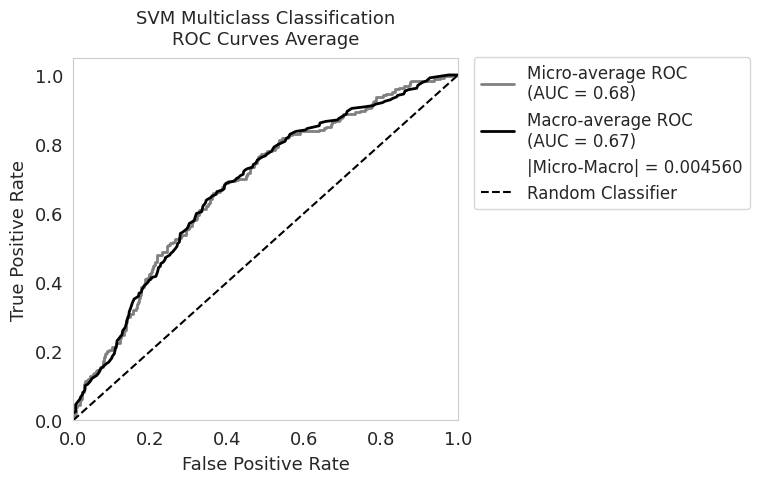

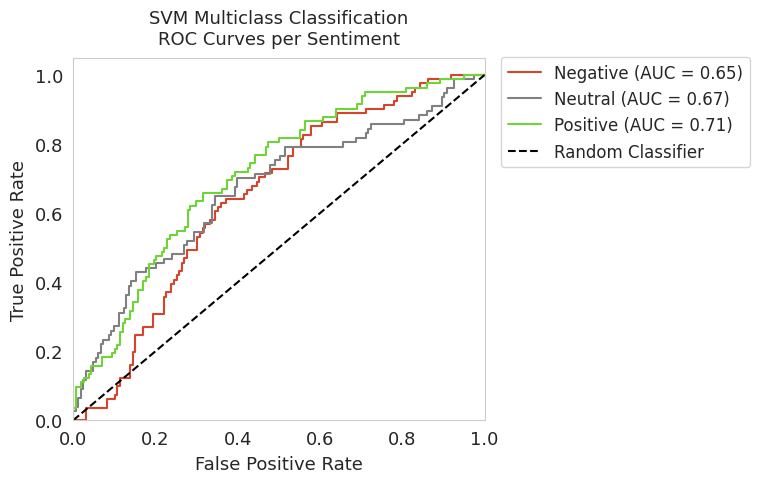

,ROC AUC,Standard Deviation,95% CI Lower,95% CI Upper,Standard Error
Average Type,,,,,
Micro,0.678967,0.026132,0.619899,0.738035,0.030137
Macro,0.674407,0.026132,0.644835,0.703978,0.015087
Weighted,0.674681,0.026373,0.615503,0.733860,0.030193
Micro-Macro Gap,0.004560,-,-,-,-



Note: A small micro-macro AUC gap indicates uniform model performance across sentiment classes.
A large micro-macro AUC gap indicates inconsistent model performance across sentiment classes.


Class,Negative,Neutral,Positive
Total Samples,240.000000,240.000000,240.000000
Positive Samples,81.000000,77.000000,82.000000
Negative Samples,159.000000,163.000000,158.000000
AUC (roc_curve),0.646945,0.666720,0.709555
AUC (roc_auc_score),0.646945,0.666720,0.709555
95% CI Lower,0.638691,0.658473,0.701738
95% CI Upper,0.655199,0.674967,0.717373
Difference between methods,0.000000,0.000000,0.000000
Optimal Threshold,0.320330,0.334459,0.332742
Precision,0.428571,0.471698,0.519231



ROC curve average metrics saved to: /workspace/Output/SVM/SVM_MC/Results/roc_curve_average_metrics.csv

ROC curve analysis saved to: /workspace/Output/SVM/SVM_MC/Results/roc_curve_analysis.csv




In [55]:
#==================================================================================================
#                 Visualizations ROC Curve using the model prodictions 
#==================================================================================================

# Seaborn setting
sns.set_style("whitegrid", {'axes.grid': False})

# Base output directory
base_dir = "/workspace/Output/SVM/SVM_MC"
predictions_dir = os.path.join(base_dir, 'Results/predictions')
figure_dir = os.path.join(base_dir, "Figures")
os.makedirs(figure_dir, exist_ok=True)

# Load and prepare data
ensemble_logits = np.load(os.path.join(predictions_dir, 'ensemble_logits.npy'))
y_test_true = np.load(os.path.join(base_dir, 'test_data/y_test.npy'))

# Softmax function for converting logits to probabilities
def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

# Convert logits to probabilities
test_pred_proba = softmax(ensemble_logits)

# Aggregate ensemble predictions (mean across models)
test_pred_proba_aggregated = test_pred_proba

# Define labels and colors
label_names = ['Negative', 'Neutral', 'Positive']
colors = ['#d5442b', 'grey', '#6fd437']




# ---------  First plot: Compute ROC curves --------- 

# Compute ROC curves
plt.figure(figsize=(7.8, 5))

# Prepare binary labels
y_test_bin = label_binarize(y_test_true, classes=range(len(label_names)))

# Compute micro-average ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_pred_proba_aggregated[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), test_pred_proba_aggregated.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], 
         label=f'Micro-average ROC\n(AUC = {roc_auc["micro"]:.2f})',
         color='gray', linestyle='-', linewidth=2)

# Compute and plot macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(label_names))]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(len(label_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(label_names)
macro_auc = np.mean([roc_auc[i] for i in range(len(label_names))])

# Calculate micro-macro difference
micro_macro_diff = abs(roc_auc["micro"] - macro_auc)

plt.plot(all_fpr, mean_tpr, 'k-',
         label=f'Macro-average ROC\n(AUC = {macro_auc:.2f})',
         linewidth=2)

# Add separate legend entry for micro-macro difference
plt.plot([], [], ' ', 
         label=f'|Micro-Macro| = {micro_macro_diff:.6f}')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Multiclass Classification\nROC Curves Average')
plt.legend(bbox_to_anchor=(1.02, 1.025), loc='upper left')
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(figure_dir, 'SVM_MC_ROC_curves_averages.png'), 
            dpi=300, bbox_inches='tight')
plt.show()



# ---------  Second plot: Per-class ROC curves --------- 
plt.figure(figsize=(7.8, 5))

# Store ROC results for reporting
roc_results = []

# Plot ROC curves for each class
for i, (class_name, color) in enumerate(zip(label_names, colors)):
    # One-vs-rest approach
    y_true_binary = (y_test_true == i).astype(int)
    y_score = test_pred_proba_aggregated[:, i]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Compute confidence interval for AUC
    n_pos = np.sum(y_true_binary)
    n_neg = len(y_true_binary) - n_pos
    se = np.sqrt((roc_auc * (1 - roc_auc)) / (n_pos * n_neg))
    ci_lower = max(0, roc_auc - 1.96 * se)
    ci_upper = min(1, roc_auc + 1.96 * se)
    
    # Store results
    roc_results.append({
        'Class': class_name,
        'AUC': roc_auc,
        'CI Lower': ci_lower,
        'CI Upper': ci_upper
    })
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=color,
             label=f'{class_name} (AUC = {roc_auc:.2f})')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Multiclass Classification\nROC Curves per Sentiment')
plt.legend(bbox_to_anchor=(1.02, 1.025), loc='upper left')
plt.tight_layout()

# Save the figure
sentiment_roc_curve_path = os.path.join(figure_dir, 'SVM_MC_ROC_curves_per_sentiment.png')
plt.savefig(sentiment_roc_curve_path, dpi=300, bbox_inches='tight')
sentiment_roc_curve_path2 = os.path.join(figure_dir, 'SVM_MC_ROC_curves_per_sentiment.tiff')
plt.savefig(sentiment_roc_curve_path2, dpi=300, bbox_inches='tight')
plt.show()



# ======================== Additional Statistics ========================

# ------------------- Calculate ROC Average Metrics ---------------------

def calculate_average_metrics(y_true, y_pred_proba, classes):
    """
    Calculate micro, macro, and weighted averages for ROC AUC scores.
    Also includes standard deviation of AUC scores across classes.
    """
    n_classes = len(classes)
    
    # Binarize the labels for multi-class metrics
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Initialize lists for storing metrics
    class_metrics = []
    class_auc_scores = []  # Initialize this list
    
    # Calculate metrics for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        class_metrics.append({
            'class': classes[i],
            'auc': roc_auc,
        })
        class_auc_scores.append(roc_auc)
    
    # Micro average
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    
    # Macro average (simple average of class-wise AUC scores)
    auc_macro = np.mean([m['auc'] for m in class_metrics])
    
    # Weighted average (weighted by class support)
    class_support = np.bincount(y_true)
    auc_weighted = np.average([m['auc'] for m in class_metrics], 
                            weights=class_support)
    
    # Calculate standard errors and confidence intervals
    n_samples = len(y_true)
    
    # Standard error for micro average
    se_micro = np.sqrt(auc_micro * (1 - auc_micro) / n_samples)
    ci_micro = (auc_micro - 1.96 * se_micro, auc_micro + 1.96 * se_micro)
    
    # Standard error for macro average
    se_macro = np.sqrt(np.var([m['auc'] for m in class_metrics]) / n_classes)
    ci_macro = (auc_macro - 1.96 * se_macro, auc_macro + 1.96 * se_macro)
    
    # Standard error for weighted average
    se_weighted = np.sqrt(np.average([(m['auc'] * (1 - m['auc'])) for m in class_metrics], 
                                   weights=class_support) / n_samples)
    ci_weighted = (auc_weighted - 1.96 * se_weighted, auc_weighted + 1.96 * se_weighted)
    
    # Calculate standard deviations
    std_across_classes = np.std(class_auc_scores)
    
    return {
        'micro': {
            'auc': auc_micro,
            'ci': ci_micro,
            'se': se_micro,
            'std': std_across_classes
        },
        'macro': {
            'auc': auc_macro,
            'ci': ci_macro,
            'se': se_macro,
            'std': std_across_classes
        },
        'weighted': {
            'auc': auc_weighted,
            'ci': ci_weighted,
            'se': se_weighted,
            'std': np.sqrt(np.average((np.array(class_auc_scores) - auc_weighted) ** 2, weights=class_support))
        },
        'class_metrics': class_metrics
    }

# Calculate average metrics
average_metrics = calculate_average_metrics(y_test_true, test_pred_proba, range(len(label_names)))

# Create a DataFrame for average metrics
average_metrics_data = []
for avg_type in ['micro', 'macro', 'weighted']:
    metrics = average_metrics[avg_type]
    average_metrics_data.append({
        'Average Type': avg_type.capitalize(),
        'ROC AUC': f"{metrics['auc']:.6f}",
        'Standard Deviation': f"{metrics['std']:.6f}",
        '95% CI Lower': f"{metrics['ci'][0]:.6f}",
        '95% CI Upper': f"{metrics['ci'][1]:.6f}",
        'Standard Error': f"{metrics['se']:.6f}"
    })

# Add the micro-macro gap row
micro_macro_gap = abs(average_metrics['micro']['auc'] - average_metrics['macro']['auc'])
average_metrics_data.append({
    'Average Type': 'Micro-Macro Gap',
    'ROC AUC': f"{micro_macro_gap:.6f}",
    'Standard Deviation': "-",
    '95% CI Lower': "-",
    '95% CI Upper': "-",
    'Standard Error': "-"
})

average_metrics_df = pd.DataFrame(average_metrics_data)
average_metrics_df = average_metrics_df.set_index('Average Type')

# Display the average metrics table
print("\n")
display(HTML('<div style="font-size: 22px; font-weight: bold;">Receiver Operating Characteristic (ROC) Curve Metrics</div>'))
display(HTML("<br><b>Area Under the Curve (AUC): ROC Curve Average Metrics</b>"))
display(HTML(average_metrics_df.to_html()))

# Save average metrics to CSV
average_metrics_save_path = os.path.join(base_dir, 'Results', 'roc_curve_average_metrics.csv')
average_metrics_df.to_csv(average_metrics_save_path, sep=';')

# Notes printing
print("\nNote: A small micro-macro AUC gap indicates uniform model performance across sentiment classes.")
print("A large micro-macro AUC gap indicates inconsistent model performance across sentiment classes.")


# ------------- ROC Curve Detailed Analysis per Sentiments -------------

detailed_roc_results = []
for i, class_name in enumerate(label_names):
    # One-vs-rest approach
    y_true_binary = (y_test_true == i).astype(int)
    y_score = test_pred_proba[:, i]
    
    # Method 1: sklearn's roc_curve
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
    
    # Method 2: Direct AUC computation
    auc_direct = auc(fpr, tpr)
    
    # Method 3: roc_auc_score
    auc_score = roc_auc_score(y_true_binary, y_score)
    
    # Additional statistical validation
    n_pos = np.sum(y_true_binary)
    n_neg = len(y_true_binary) - n_pos
    
    # Confidence interval for AUC
    se = np.sqrt((auc_direct * (1 - auc_direct)) / (n_pos * n_neg))
    ci_lower = max(0, auc_direct - 1.96 * se)
    ci_upper = min(1, auc_direct + 1.96 * se)
    
    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Calculate metrics at optimal threshold
    y_pred_threshold = (y_score >= optimal_threshold).astype(int)
    
    precision = precision_score(y_true_binary, y_pred_threshold, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_threshold, zero_division=0)
    
    # Store results
    result = {
        'Class': class_name,
        'Total Samples': len(y_true_binary),
        'Positive Samples': n_pos,
        'Negative Samples': n_neg,
        'AUC (roc_curve)': auc_direct,
        'AUC (roc_auc_score)': auc_score,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper,
        'Difference between methods': abs(auc_direct - auc_score),
        'Optimal Threshold': optimal_threshold,
        'Precision': precision,
        'Recall': recall
    }
    
    detailed_roc_results.append(result)

# Create a transposed DataFrame for better readability
roc_analysis_df = pd.DataFrame(detailed_roc_results).set_index('Class').T

# format float columns to a specific number of decimal places
float_columns = roc_analysis_df.select_dtypes(include=[np.float64]).columns
for col in float_columns:
    roc_analysis_df[col] = roc_analysis_df[col].apply(lambda x: f"{x:.6f}" if pd.notnull(x) else x)

# Save to CSV
save_path = os.path.join(base_dir, 'Results', 'roc_curve_analysis.csv')
roc_analysis_df.to_csv(save_path, sep=';')

# Display in Jupyter Notebook
display(HTML("<br><b>\nROC Curve Analysis by Sentiment</b>"))
display(HTML(roc_analysis_df.to_html()))
print(f"\nROC curve average metrics saved to: {average_metrics_save_path}")
print(f"\nROC curve analysis saved to: {save_path }\n\n")


### Probability Distributions for Multilabel Classification

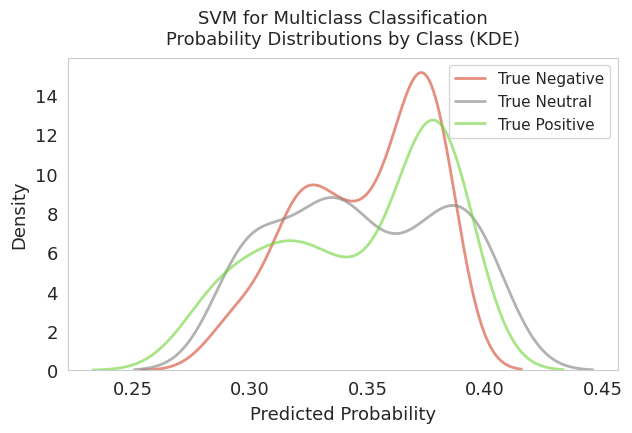

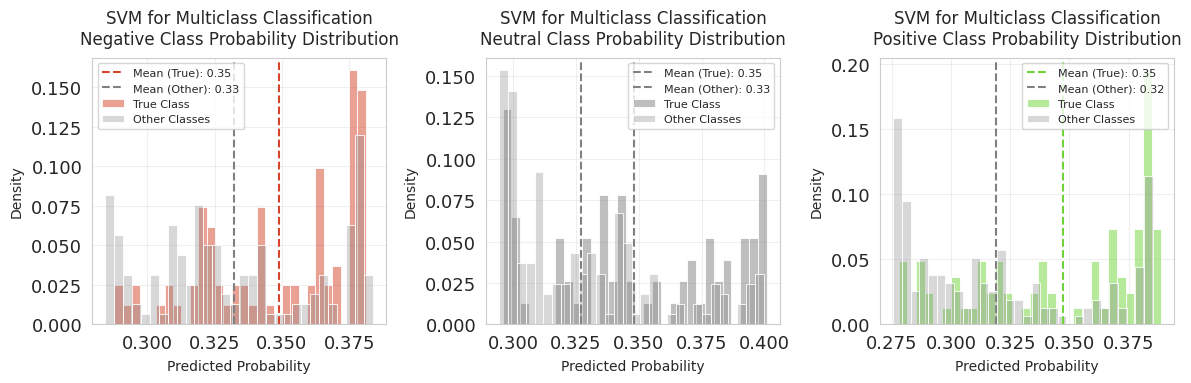

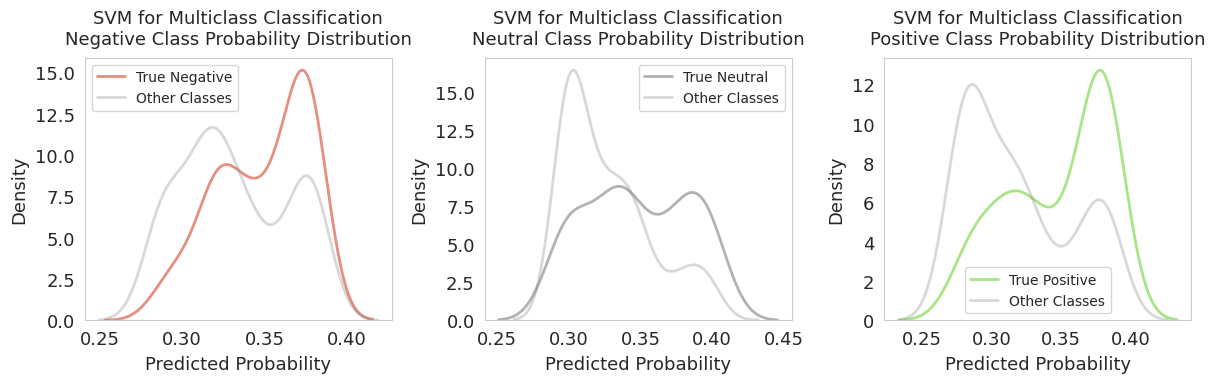

,True Class (Mean),True Class (Std),Other Classes (Mean),Other Classes (Std),Separation
Metric,,,,,
Negative,0.348846,0.027406,0.332033,0.031944,0.016813
Neutral,0.348169,0.035358,0.326991,0.030149,0.021178
Positive,0.347307,0.035778,0.318750,0.037836,0.028557


In [22]:
# ==================== Visualize Probability Distributions ====================

# --------------- KDE Plot All Sentiement ---------------

plt.figure(figsize=(6.5, 4.5))
for i, (class_name, color) in enumerate(zip(label_names, colors)):
    class_probs = test_pred_proba[:, i]
    true_class = (y_test_true == i)
    
    # Plot distributions
    sns.kdeplot(data=class_probs[true_class], color=color, alpha=0.6, 
                label=f'True {class_name}', linewidth=2)

plt.title('SVM for Multiclass Classification\nProbability Distributions by Class (KDE)')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend(fontsize=11)
plt.grid(False)
plt.tight_layout()

# Save the figure
prob_path = os.path.join(figure_dir, 'SVM_MC_probability_distributions.png')
plt.savefig(prob_path, dpi=300, bbox_inches='tight')
display(HTML('<div style="font-size: 22px; font-weight: bold;">Probability Distributions</div>'))

plt.show()

# ================== Enhanced Probability Distribution Visualization ===================

plt.figure(figsize=(12, 4))
for i, class_name in enumerate(label_names):
    plt.subplot(1, 3, i+1)
    # Get probabilities for the current class
    class_probs = test_pred_proba[:, i]
    # Get true labels for this class
    true_class = (y_test_true == i)
    
    # Plot distributions separately for true positives and true negatives
    sns.histplot(data=class_probs[true_class], bins=30, color=colors[i], alpha=0.5, 
                label='True Class', stat='probability')
    sns.histplot(data=class_probs[~true_class], bins=30, color='gray', alpha=0.3, 
                label='Other Classes', stat='probability')
    
    # Add mean lines
    plt.axvline(class_probs[true_class].mean(), color=colors[i], linestyle='--', 
                label=f'Mean (True): {class_probs[true_class].mean():.2f}')
    plt.axvline(class_probs[~true_class].mean(), color='gray', linestyle='--', 
                label=f'Mean (Other): {class_probs[~true_class].mean():.2f}')
    
    plt.title(f'SVM for Multiclass Classification\n{class_name} Class Probability Distribution', fontsize=12)
    plt.xlabel('Predicted Probability', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
roc_curve_path = os.path.join(figure_dir, 'SVM_MC_probability_distributions_hist_true_false.png')
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()

# --------------- KDE Plot - separate plots for each class ---------------
plt.figure(figsize=(12, 4))

for i, (class_name, color) in enumerate(zip(label_names, colors)):
    plt.subplot(1, 3, i+1)
    
    # Get probabilities for current class
    class_probs = test_pred_proba[:, i]
    true_class = (y_test_true == i)
    
    # Plot distributions
    sns.kdeplot(data=class_probs[true_class], color=color, alpha=0.6, 
                label=f'True {class_name}', linewidth=2)
    sns.kdeplot(data=class_probs[~true_class], color='gray', alpha=0.3, 
                label=f'Other Classes', linewidth=2)
    
    plt.title(f'SVM for Multiclass Classification\n{class_name} Class Probability Distribution')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend(fontsize=10)
    plt.grid(False)

plt.tight_layout()

# Save the figure
roc_curve_path = os.path.join(figure_dir, 'SVM_MC_probability_distributions_KDE_true_false.png')
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()

# ================== Print distribution statistics ==================
# Create and display probability distribution statistics table
prob_stats = []
metrics = ['True Class (Mean)', 'True Class (Std)', 'Other Classes (Mean)', 
          'Other Classes (Std)', 'Separation']

for i, class_name in enumerate(label_names):
    class_probs = test_pred_proba[:, i]
    true_class = (y_test_true == i)
    
    stats = {
        'Metric': class_name,
        'True Class (Mean)': f"{class_probs[true_class].mean():.6f}",
        'True Class (Std)': f"{class_probs[true_class].std():.6f}",
        'Other Classes (Mean)': f"{class_probs[~true_class].mean():.6f}",
        'Other Classes (Std)': f"{class_probs[~true_class].std():.6f}",
        'Separation': f"{class_probs[true_class].mean() - class_probs[~true_class].mean():.6f}"
    }
    prob_stats.append(stats)

# Create DataFrame and display
prob_stats_df = pd.DataFrame(prob_stats).set_index('Metric')
display(HTML("<br><b>Probability Distribution Statistics</b>"))
display(HTML(prob_stats_df.to_html()))

### Confusion Matrices for Multilabel Classification

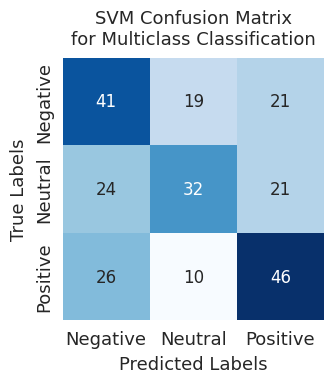

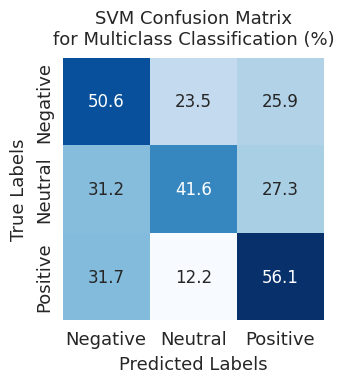


Sentiment Distribution:


,True Label,Predictions
Sentiment,,
Negative,81,91
Neutral,77,61
Positive,82,88



Sentiment Distribution table saved in: /workspace/Output/SVM/SVM_MC/Results SVM_MC_Sentiment_Distribution.csv

Classification Report:


,precision,recall,f1-score,support
Negative,0.450549,0.506173,0.476744,81.000000
Neutral,0.524590,0.415584,0.463768,77.000000
Positive,0.522727,0.560976,0.541176,82.000000
accuracy,0.495833,0.495833,0.495833,0.495833
macro avg,0.499289,0.494244,0.493896,240.000000
weighted avg,0.498965,0.495833,0.494595,240.000000



Additional Statistical Metrics:


,Metric,Value
0,Macro Accuracy,0.495833
1,Macro Precision,0.499289
2,Macro Recall,0.494244
3,Macro F1-Score,0.493896
4,Cohen's Kappa,0.242092



Analysis complete. Results saved in: /workspace/Output/SVM/SVM_MC/Results


In [56]:
#==================================================================================================
#                 Visualizations of Confusion Matrices and Sentiment Distribution 
#==================================================================================================


# ============== Peparing Data ================

# Using the data from ROC curve analysis
# Convert numeric predictions to string labels
y_true_str = [label_names[i] for i in y_test_true]
y_pred = np.argmax(test_pred_proba, axis=1)
y_pred_str = [label_names[i] for i in y_pred]

# Create output directory if it doesn't exist
output_dir = os.path.join(base_dir, 'Results')
os.makedirs(output_dir, exist_ok=True)

def compute_statistical_metrics(y_true, y_pred, labels):
    """Compute additional statistical metrics"""
    # Create copies of input data
    y_true_copy = np.array(y_true).copy()
    y_pred_copy = np.array(y_pred).copy()
    
    label_map = {label: idx for idx, label in enumerate(labels)}
    y_true_numeric = np.array([label_map[label] for label in y_true_copy])
    y_pred_numeric = np.array([label_map[label] for label in y_pred_copy])
    
    results = {
        'Macro Accuracy': accuracy_score(y_true_numeric, y_pred_numeric, normalize=True),
        'Macro Precision': precision_score(y_true_numeric, y_pred_numeric, average='macro'),
        'Macro Recall': recall_score(y_true_numeric, y_pred_numeric, average='macro'),
        'Macro F1-Score': f1_score(y_true_numeric, y_pred_numeric, average='macro'),
        'Cohen\'s Kappa': cohen_kappa_score(y_true_numeric, y_pred_numeric)        
    }
    
    return results.copy()

# ============== Confusion Matrix Visualization ================

# ------ Counts version ------
cm = confusion_matrix(y_true_str, y_pred_str, labels=label_names)

plt.figure(figsize=(3.5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title('SVM Confusion Matrix\nfor Multiclass Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'SVM_MC_confusion_matrix_counts.png'), 
            dpi=300, 
            bbox_inches='tight')
plt.show()

# ------ Percentage version ------
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)

plt.figure(figsize=(3.5, 4))
sns.heatmap(
    cm_normalized * 100,
    annot=np.round(cm_normalized * 100, 1),
    fmt='.1f',
    cmap='Blues',
    cbar=False,
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title('SVM Confusion Matrix\nfor Multiclass Classification (%)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'SVM_MC_confusion_matrix_percentage.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, 'SVM_MC_confusion_matrix_percentage.tiff'), dpi=300, bbox_inches='tight')
plt.show()

# ============== Basic Distribution Analysis ================

# Create DataFrames for True Label and Prediction distributions
true_label_dist = pd.Series(y_true_str).value_counts().reset_index()
true_label_dist.columns = ['Sentiment', 'True Label']

prediction_dist = pd.Series(y_pred_str).value_counts().reset_index()
prediction_dist.columns = ['Sentiment', 'Predictions']

# Merge the two DataFrames
distribution_table = pd.merge(true_label_dist, prediction_dist, on='Sentiment', how='outer').fillna(0)

# Reorder rows to match the desired order
distribution_table['Sentiment'] = pd.Categorical(distribution_table['Sentiment'], categories=label_names, ordered=True)
distribution_table = distribution_table.sort_values('Sentiment')

# Reset index and set Sentiment as index
distribution_table = distribution_table.reset_index(drop=True).set_index('Sentiment')

# Convert counts to integers
distribution_table = distribution_table.astype(int)

print("\nSentiment Distribution:")
display(distribution_table)

# Save the distribution table
distribution_table.to_csv(os.path.join(output_dir, 'SVM_MC_Sentiment_Distribution.csv'))
print("\nSentiment Distribution table saved in:", output_dir, 'SVM_MC_Sentiment_Distribution.csv')

# Calculate accuracy
accuracy = np.mean(np.array(y_true_str) == np.array(y_pred_str))

# Classification report
print("\nClassification Report:")
class_report = classification_report(y_true_str, y_pred_str, labels=label_names, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
display(class_report_df)

# Additional metrics
additional_metrics = compute_statistical_metrics(y_true_str, y_pred_str, label_names)

print("\nAdditional Statistical Metrics:")
additional_metrics_df = pd.DataFrame.from_dict(additional_metrics, orient='index', columns=['Value'])
additional_metrics_df.index.name = 'Metric'
additional_metrics_df = additional_metrics_df.reset_index()

def format_value(x):
    if isinstance(x, dict):
        return ', '.join([f"{k}: {v:.6f}" for k, v in x.items()])
    elif isinstance(x, (int, float)):
        return f'{x:.6f}'
    return str(x)

additional_metrics_df['Value'] = additional_metrics_df['Value'].apply(format_value)
pd.set_option('display.max_colwidth', None)
display(additional_metrics_df)

print("\nAnalysis complete. Results saved in:", output_dir)

# SVM model - Multilabel classification

## Multilabel & text: preparing data

In [24]:
# Extracting features (text) and labels from training DataFrame
X_train_ML = trainDf['text'].tolist()
y_train_ML = trainDf[['Label_A2_negative', 'Label_A3_neutral', 'Label_A1_positive']].values

# Extracting features (text) and labels from validation DataFrame
X_val_ML = valDf['text'].tolist()
y_val_ML = valDf[['Label_A2_negative', 'Label_A3_neutral', 'Label_A1_positive']].values

# Extracting features (text) and labels from test DataFrame
X_test_ML = testDf['text'].tolist()
y_test_ML = testDf[['Label_A2_negative', 'Label_A3_neutral', 'Label_A1_positive']].values

# Convert X_train_ML to NumPy array
X_train_ML = np.array(X_train_ML)
X_val_ML = np.array(X_val_ML)
X_test_ML = np.array(X_test_ML)

## Metric functions (F1 score, hamming loss, etc.)

In [25]:
## =================== Metrics Definition for Multilabel classification ===================

def ML_metric2(y_true, y_pred):
    """
    Calculate the proportion of predictions that are exactly correct or off by one.
    For a 3-class sentiment problem (0, 1, 2), count how many labels are correctly predicted
    or predicted with just one level difference.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    n_samples = y_true.shape[0]
    correct_predictions = 0
    
    for i in range(n_samples):
        # Get true and predicted class indices
        true_idx = np.where(y_true[i] == 1)[0]
        pred_idx = np.where(y_pred[i] == 1)[0]
        
        # Check if we have valid indices
        if len(true_idx) == 1 and len(pred_idx) == 1:
            # Calculate absolute difference between predicted and true class
            diff = abs(true_idx[0] - pred_idx[0])
            # Count as correct if exact match or off by one
            if diff <= 1:
                correct_predictions += 1
    
    return correct_predictions / n_samples

def ML_hamming_score(y_true, y_pred):
    """
    Calculate the Hamming score (intersection over union) for multilabel classification.
    """
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)
    
    intersection = np.sum(y_true & y_pred)
    union = np.sum(y_true | y_pred)
    
    return intersection / union if union > 0 else 0

def ML_weighted_accuracy(y_true, y_pred):
    """
    Calculate weighted accuracy for multi-label classification.
    """
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)
    
    n_classes = y_true.shape[1]
    class_accuracies = []
    weights = []
    
    for c in range(n_classes):
        true_class = y_true[:, c]
        pred_class = y_pred[:, c]
        
        n_samples_class = np.sum(true_class)
        if n_samples_class == 0:
            continue
        
        weight = y_true.shape[0] / (n_classes * n_samples_class)
        class_accuracy = np.sum((true_class == 1) & (pred_class == 1)) / n_samples_class
        
        class_accuracies.append(class_accuracy)
        weights.append(weight)
    
    weights = np.array(weights)
    weights = weights / np.sum(weights)
    
    return np.sum(np.array(class_accuracies) * weights)

def ML_macro_f1(y_true, y_pred):
    """
    Compute the macro F1 score for multi-label classification.
    """
    f1_scores = []
    for c in range(y_true.shape[1]):
        f1 = f1_score(y_true[:, c], y_pred[:, c])
        f1_scores.append(f1)
    
    return np.mean(f1_scores)

def ML_weighted_f1(y_true, y_pred):
    """
    Compute the weighted F1 score for multi-label classification.
    """
    f1_scores = []
    weights = []
    
    for c in range(y_true.shape[1]):
        n_samples_class = np.sum(y_true[:, c])
        if n_samples_class == 0:
            continue
        
        weight = n_samples_class / np.sum(y_true)
        f1 = f1_score(y_true[:, c], y_pred[:, c])
        
        f1_scores.append(f1)
        weights.append(weight)
    
    return np.average(f1_scores, weights=weights)


def ML_hamming_loss(y_true, y_pred):
    """
    Calculate Hamming loss for multi-label classification.
    """
    return hamming_loss(y_true, y_pred)

def ML_macro_accuracy(y_true, y_pred):
    """
    Calculate macro-averaged accuracy for multi-label classification.
    """
    accuracies = []
    for c in range(y_true.shape[1]):
        true_class = y_true[:, c]
        pred_class = y_pred[:, c]
        class_accuracy = np.mean(true_class == pred_class)
        accuracies.append(class_accuracy)
    
    return np.mean(accuracies)

## Optuna Hyperparameters Optimization

In [26]:
# ===========================================================================================
#              Optuna Bayesian Hyperparameters Optimization for SVM Model
#                             Multilabel classification
# ===========================================================================================

import os
import json
import numpy as np
import pandas as pd
import optuna
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, hamming_loss
from sklearn.model_selection import cross_val_score
import warnings
from datetime import datetime

# Suppress warnings
warnings.filterwarnings('ignore')

# Configuration dictionary
CONFIG = {
    'tfidf': {
        'ngram_range': [(1, 1), (1, 2), (1, 3)],
        'max_features': [2500, 3000, 3500]
    },
    'svm': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'degree': [3, 4, 5],
        'max_iter': 3000,
        'tol': 0.01,
        'verbose': False,
        'n_labels': 3
    }
}

class MultilabelBalancedScorer:
    def __call__(self, estimator, X, y_true):
        y_pred = estimator.predict(X)
        macro_f1 = f1_score(y_true, y_pred, average='macro')
        hl = hamming_loss(y_true, y_pred)
        cv_stability = 0.8  # Placeholder value
        return self.calculate_balanced_score(macro_f1, hl, cv_stability)
    
    def calculate_balanced_score(self, macro_f1, hamming_loss, cv_stability):
        max_hamming_loss = 0.5
        normalized_hamming_loss = 1 - (min(hamming_loss, max_hamming_loss) / max_hamming_loss)
        return (0.4 * macro_f1) + (0.3 * normalized_hamming_loss) + (0.3 * cv_stability)

def create_model(trial):
    ngram_range = CONFIG['tfidf']['ngram_range'][trial.suggest_int('ngram_range_idx', 0, len(CONFIG['tfidf']['ngram_range'])-1)]
    max_features = CONFIG['tfidf']['max_features'][trial.suggest_int('max_features_idx', 0, len(CONFIG['tfidf']['max_features'])-1)]
    C = CONFIG['svm']['C'][trial.suggest_int('C_idx', 0, len(CONFIG['svm']['C'])-1)]
    kernel = trial.suggest_categorical('kernel', CONFIG['svm']['kernel'])
    gamma = CONFIG['svm']['gamma'][trial.suggest_int('gamma_idx', 0, len(CONFIG['svm']['gamma'])-1)]
    degree = CONFIG['svm']['degree'][trial.suggest_int('degree_idx', 0, len(CONFIG['svm']['degree'])-1)]
    ngram_range = trial.suggest_categorical('ngram_range', CONFIG['tfidf']['ngram_range'])
    max_features = trial.suggest_categorical('max_features', CONFIG['tfidf']['max_features'])
    tfidf = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    svc = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, max_iter=CONFIG['svm']['max_iter'],
              tol=CONFIG['svm']['tol'], verbose=CONFIG['svm']['verbose'], random_state=42, probability=True)
    
    return tfidf, MultiOutputClassifier(svc, n_jobs=-1)

def objective(trial):
    tfidf, model = create_model(trial)
    X_train_tfidf = tfidf.fit_transform(X_train_ML)
    scorer = MultilabelBalancedScorer()
    scores = cross_val_score(model, X_train_tfidf, y_train_ML, scoring=scorer, cv=5, n_jobs=-1)
    return scores.mean()

# Set up the study
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))

# Run optimization
n_trials = 35
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Get best parameters
best_params = {
    'tfidf__ngram_range': study.best_params['ngram_range'],
    'tfidf__max_features': study.best_params['max_features'],
    'svm__C': CONFIG['svm']['C'][study.best_params['C_idx']],
    'svm__kernel': study.best_params['kernel'],
    'svm__gamma': CONFIG['svm']['gamma'][study.best_params['gamma_idx']],
    'svm__degree': CONFIG['svm']['degree'][study.best_params['degree_idx']]
}

print("Best parameters:", best_params)
print("Best score:", study.best_value)

# Create and train best model
tfidf, best_model = create_model(study.best_trial)
X_train_tfidf = tfidf.fit_transform(X_train_ML)
X_val_tfidf = tfidf.transform(X_val_ML)
best_model.fit(X_train_tfidf, y_train_ML)

# Evaluate on validation set
scorer = MultilabelBalancedScorer()
validation_score = scorer(best_model, X_val_tfidf, y_val_ML)
print("Validation set score:", validation_score)

# Save results
save_dir = '/workspace/Output/SVM/SVM_ML/Optuna_search'
os.makedirs(save_dir, exist_ok=True)

# Save results to CSV
results_df = study.trials_dataframe()
results_df.to_csv(os.path.join(save_dir, 'SVM_multilabel_optuna_results.csv'), index=False, sep=';')

# Save best parameters as JSON
with open(os.path.join(save_dir, 'SVM_multilabel_optuna_best_params.json'), 'w') as f:
    json.dump(best_params, f, indent=4)

# Save study object
import joblib
joblib.dump(study, os.path.join(save_dir, 'optuna_study_multilabel.pkl'))


[I 2025-01-11 17:22:40,886] A new study created in memory with name: no-name-d1da400f-d079-42e4-91a3-cbc7b1ced3a5


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2025-01-11 17:22:41,321] Trial 0 finished with value: 0.4775785268442242 and parameters: {'ngram_range_idx': 1, 'max_features_idx': 2, 'C_idx': 2, 'kernel': 'rbf', 'gamma_idx': 0, 'degree_idx': 2, 'ngram_range': (1, 2), 'max_features': 2500}. Best is trial 0 with value: 0.4775785268442242.
[I 2025-01-11 17:22:41,770] Trial 1 finished with value: 0.30934149184149184 and parameters: {'ngram_range_idx': 0, 'max_features_idx': 0, 'C_idx': 1, 'kernel': 'rbf', 'gamma_idx': 2, 'degree_idx': 0, 'ngram_range': (1, 3), 'max_features': 2500}. Best is trial 0 with value: 0.4775785268442242.
[I 2025-01-11 17:22:42,214] Trial 2 finished with value: 0.30934149184149184 and parameters: {'ngram_range_idx': 1, 'max_features_idx': 0, 'C_idx': 2, 'kernel': 'poly', 'gamma_idx': 3, 'degree_idx': 2, 'ngram_range': (1, 3), 'max_features': 3500}. Best is trial 0 with value: 0.4775785268442242.
[I 2025-01-11 17:22:42,592] Trial 3 finished with value: 0.30934149184149184 and parameters: {'ngram_range_idx': 0,

['/workspace/Output/SVM/SVM_ML/Optuna_search/optuna_study_multilabel.pkl']

## Ensemble Model Learning for Multilabel Classification - testing with the Optuna hyperparameters
This approach involves the following key steps:
- **Data Stratification**:<br>
Utilize StratifiedKFold to ensure balanced class distribution across all folds, maintaining representative data splits.

- **Multiple Model Training**:<br>
Perform 5-fold cross-validation to obtain 5 models trained in different data subsets, following a systematic cross-validation training pipeline.

- **Model Building**:<br>
Instead of selecting a single best model, all 5 models trained are retained, with each training process employing early stopping based on a custom composite metric:
  - 40% Weighted F1 Score
  - 30% Hamming Loss
  - 30% CV Stability

- **Model Averaging**:<br>
For final prediction on the test set:<br>
  - Use each of the 5 fold models to make predictions<br>
  - Implement soft voting by averaging prediction probabilities from all models<br>
  - Generate final ensemble prediction based on highest average probability<br>

- **Evaluation of Ensemble Predictions**:<br>
The ensemble predictions are evaluated on the test set to assess performance, combining the strengths of multiple models through the ensemble learning approach.

In [27]:

# ===========================================================================================================
#                SVM - Training, Validation and Testing for Multilabel classification
# ===========================================================================================================

import os
import json
import numpy as np
import pandas as pd
import torch
import scipy.sparse
import scipy.stats
import traceback
import logging
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    hamming_loss, f1_score, precision_score, recall_score
)

# System Information
SYSTEM_CONFIG = {
    'gpu': 'NVIDIA L4',
    'cuda_version': '12.4',
    'pytorch_version': '2.5.1',
    'gpu_memory': '24GB',
    'max_power': '72W'
}

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# GPU settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# Configuration
CONFIG = {
    'model_params': {
        'max_features': 3000,
        'ngram_range': (1, 3),
        'C': 100,
        'kernel': 'linear',
        'gamma': 'auto',
        'degree': 5,
        
        # Added new parameters
        'decision_function_shape': 'ovr',
        'max_iter': 3000,
        'tol': 0.01,
        'verbose': False,
        'n_labels': 3,
        'random_state': 42,
        'class_weight': None  # False = None in sklearn
    },
    'training_params': {
        'n_splits': 5,
        'random_seed': 42
    },
    'ensemble_params': {
        'voting': 'soft',
        'weights': None
    }
}

print("\n" + "="*50)
print("Configuration:")
print("="*50)
for section, params in CONFIG.items():
    print(f"\n{section}:")
    for param, value in params.items():
        print(f"  {param}: {value}")
print("="*50 + "\n")

def create_folds(X, y, num_folds=5):
    """
    Create stratified folds for multilabel data
    
    Args:
        X (array-like or sparse matrix): Input features
        y (array-like): Multi-label target values
        num_folds (int, optional): Number of folds. Defaults to 5.
    
    Returns:
        list: List of fold indices (train_idx, val_idx)
    """
    # Convert X to numpy array if it's a sparse matrix
    if scipy.sparse.issparse(X):
        X_array = X.toarray()
    else:
        X_array = np.array(X)
    
    # Ensure numpy arrays
    y = np.array(y)
    
    # Validate input
    if X_array.shape[0] != len(y):
        raise ValueError("Number of samples in X and y must be the same")
    
    # If num_folds is greater than number of samples, reduce it
    num_folds = min(num_folds, len(y))
    
    # Create a single stratification label
    def create_stratification_label(multilabel_row):
        """
        Convert multilabel row to a single stratification label
        
        Args:
            multilabel_row (np.ndarray): Binary multilabel row
        
        Returns:
            int: Stratification label
        """
        # Count of positive labels
        return np.sum(multilabel_row)
    
    # Compute stratification labels
    stratify_labels = np.array([create_stratification_label(row) for row in y])
    
    # Try StratifiedKFold first
    try:
        skf = StratifiedKFold(
            n_splits=num_folds, 
            shuffle=True, 
            random_state=RANDOM_SEED
        )
        folds = list(skf.split(X_array, stratify_labels))
        return folds
    
    except ValueError:
        # Fallback to KFold if stratification fails
        kf = KFold(
            n_splits=num_folds, 
            shuffle=True, 
            random_state=RANDOM_SEED
        )
        return list(kf.split(X_array))
        
def calculate_balanced_score(macro_f1, hamming_loss, cv_stability):
    """
    Calculate balanced score using the specified weights:
    - 40% Macro F1 Score
    - 30% Normalized Hamming Loss
    - 30% CV Stability
    """
    # Normalize hamming loss (lower is better)
    max_hamming_loss = 0.5  # typical max value for hamming loss
    normalized_hamming_loss = 1 - (min(hamming_loss, max_hamming_loss) / max_hamming_loss)
    
    # Calculate final score
    score = (0.4 * macro_f1) + (0.3 * normalized_hamming_loss) + (0.3 * cv_stability)
    return score
    
def calculate_qcd(scores):
    """Calculate Quality Control Distance (QCD)"""
    return 1.96 * np.std(scores) / np.sqrt(len(scores))

def calculate_cv_percentage(mean, std):
    """Calculate Coefficient of Variation (CV) as percentage"""
    return (std / mean * 100) if mean != 0 else 0

def calculate_cv_stability(cv_scores):
    """Calculate CV stability based on coefficient of variation"""
    cv = np.std(cv_scores) / np.mean(cv_scores) if np.mean(cv_scores) != 0 else 0
    stability = 1 / (1 + cv)
    return stability

def create_metrics_dataframe(cv_scores):
    """Create a pandas DataFrame with all metrics and statistics"""
    metrics_data = []
    
    for metric, scores in cv_scores.items():
        if len(scores) > 0:  # Only process metrics that have scores
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            cv_pct = calculate_cv_percentage(mean_score, std_score)
            qcd = calculate_qcd(scores)
            
            metrics_data.append({
                'Metric': metric,
                'Mean': mean_score,
                'Std': std_score,
                'CV (%)': cv_pct,
                'QCD': qcd
            })
    
    df_metrics = pd.DataFrame(metrics_data)
    
    # Updated metric order for multilabel
    metric_order = [
        'macro_accuracy', 'weighted_accuracy', 'hamming_score',
        'metric2',
        'macro_precision', 'micro_precision', 'weighted_precision', 'samples_precision',
        'macro_recall', 'micro_recall', 'weighted_recall', 'samples_recall',
        'macro_f1', 'micro_f1', 'weighted_f1', 'samples_f1',
        'hamming_loss', 'subset_accuracy',
        'label_cardinality', 'label_density',
        'calibration_loss'
    ]
    
    # Filter and sort by available metrics
    available_metrics = [m for m in metric_order if m in df_metrics['Metric'].values]
    df_metrics['Metric'] = pd.Categorical(df_metrics['Metric'], categories=available_metrics, ordered=True)
    df_metrics = df_metrics.sort_values('Metric').reset_index(drop=True)
    df_metrics['CV (%)'] = df_metrics['CV (%)'].apply(lambda x: f"{x:.2f}%")
    
    return df_metrics

def create_test_results_df(cv_scores, y_test, y_test_pred, y_test_pred_proba):
    """Create comprehensive test results DataFrame for multilabel classification"""
    metrics_data = []
    metrics_mapping = {
        'Accuracy (Macro)': (ML_macro_accuracy, 'macro_accuracy'),
        'Accuracy (Micro)': (ML_macro_accuracy, 'macro_accuracy'),
        'Accuracy (Weighted)': (ML_macro_accuracy, 'macro_accuracy'),
        'Metric2': (ML_metric2, 'metric2'),
        'Precision (Macro)': (lambda yt, yp: precision_score(yt, yp, average='macro', zero_division=0), 'macro_precision'),
        'Precision (Micro)': (lambda yt, yp: precision_score(yt, yp, average='micro', zero_division=0), 'micro_precision'),
        'Precision (Weighted)': (lambda yt, yp: precision_score(yt, yp, average='weighted', zero_division=0), 'weighted_precision'),
        'Precision (Samples)': (lambda yt, yp: precision_score(yt, yp, average='samples', zero_division=0), 'samples_precision'),
        'Recall (Macro)': (lambda yt, yp: recall_score(yt, yp, average='macro', zero_division=0), 'macro_recall'),
        'Recall (Micro)': (lambda yt, yp: recall_score(yt, yp, average='micro', zero_division=0), 'micro_recall'),
        'Recall (Weighted)': (lambda yt, yp: recall_score(yt, yp, average='weighted', zero_division=0), 'weighted_recall'),
        'Recall (Samples)': (lambda yt, yp: recall_score(yt, yp, average='samples', zero_division=0), 'samples_recall'),
        'F1-Score (Macro)': (lambda yt, yp: f1_score(yt, yp, average='macro', zero_division=0), 'macro_f1'),
        'F1-Score (Micro)': (lambda yt, yp: f1_score(yt, yp, average='micro', zero_division=0), 'micro_f1'),
        'F1-Score (Weighted)': (lambda yt, yp: f1_score(yt, yp, average='weighted', zero_division=0), 'weighted_f1'),
        'F1-Score (Samples)': (lambda yt, yp: f1_score(yt, yp, average='samples', zero_division=0), 'samples_f1'),
        'Hamming Loss': (ML_hamming_loss, 'hamming_loss'),
        'Subset Accuracy': (accuracy_score, 'subset_accuracy'),
        'Label Cardinality': (lambda yt, yp: np.mean(np.sum(yt, axis=1)), 'label_cardinality'),
        'Label Density': (lambda yt, yp: np.mean(np.sum(yt, axis=1)) / yt.shape[1], 'label_density')
    }
    
    for metric_name, (metric_func, cv_key) in metrics_mapping.items():
        # Calculate ensemble score
        ensemble_score = metric_func(y_test, y_test_pred)
        
        # Initialize metric data
        metric_data = {
            'Metric': metric_name,
            'Ensemble Score': ensemble_score
        }
        
        # If we have CV scores for this metric and they're not empty, add the additional statistics
        if cv_key and cv_key in cv_scores and len(cv_scores[cv_key]) > 0:
            cv_metric_scores = cv_scores[cv_key]
            individual_mean = np.mean(cv_metric_scores)
            individual_std = np.std(cv_metric_scores)
            
            # Calculate confidence interval using scipy.stats
            sem = scipy.stats.sem(cv_metric_scores)
            ci = scipy.stats.t.interval(
                confidence=0.95,
                df=len(cv_metric_scores)-1,
                loc=individual_mean,
                scale=sem
            )
            
            metric_data.update({
                'Individual Mean': individual_mean,
                'Individual Std': individual_std,
                'CI Lower': ci[0],
                'CI Upper': ci[1],
                'Best Fold Score': max(cv_metric_scores),
                'Worst Fold Score': min(cv_metric_scores)
            })
        else:
            # For metrics without CV scores, fill with NA
            metric_data.update({
                'Individual Mean': np.nan,
                'Individual Std': np.nan,
                'CI Lower': np.nan,
                'CI Upper': np.nan,
                'Best Fold Score': np.nan,
                'Worst Fold Score': np.nan
            })
        
        metrics_data.append(metric_data)
    
    df = pd.DataFrame(metrics_data)
    
    # Add per-class metrics if needed
    class_metrics = calculate_per_class_metrics(y_test, y_test_pred)
    
    return df, class_metrics

def calculate_per_class_metrics(y_true, y_pred):
    """Calculate per-class metrics for detailed analysis"""
    n_classes = y_true.shape[1]
    per_class_metrics = []
    
    # Define class names
    class_names = {
        0: 'Negative',
        1: 'Neutral',
        2: 'Positive'
    }
    
    for i in range(n_classes):
        metrics = {
            'Class': class_names[i],
            'Precision': precision_score(y_true[:, i], y_pred[:, i], zero_division=0),
            'Recall': recall_score(y_true[:, i], y_pred[:, i], zero_division=0),
            'F1-Score': f1_score(y_true[:, i], y_pred[:, i], zero_division=0),
            'Support': np.sum(y_true[:, i]),
            'Predicted Positives': np.sum(y_pred[:, i])
        }
        per_class_metrics.append(metrics)
    
    # Create DataFrame and format numbers
    df = pd.DataFrame(per_class_metrics)
    for col in ['Precision', 'Recall', 'F1-Score']:
        df[col] = df[col].map('{:.3f}'.format)
    
    return df

def save_ensemble_predictions(y_test_pred, y_test_pred_proba, predictions_dir):
    """
    Save ensemble predictions and logits for multilabel classification
    
    Args:
        y_test_pred: Binary predictions array (n_samples, n_classes)
        y_test_pred_proba: List of probability arrays for each class
        predictions_dir: Directory to save the predictions
    """
    import numpy as np
    import os
    
    # Convert predictions to numpy array if not already
    y_test_pred = np.array(y_test_pred)
    
    # Initialize array for storing probabilities
    n_samples = y_test_pred.shape[0]
    n_classes = y_test_pred.shape[1]  # 3 classes: negative, neutral, positive
    ensemble_probas = np.zeros((n_samples, n_classes))
    
    # Restructure probabilities from list of class probability arrays
    for i in range(n_classes):
        # Each element in y_test_pred_proba is a list of probabilities for one class
        class_probas = y_test_pred_proba[i]
        # Get the probability of positive class (class 1) for each sample
        ensemble_probas[:, i] = np.array([proba[1] for proba in class_probas])
    
    # Calculate logits from probabilities
    epsilon = 1e-15  # Small value to avoid division by zero
    ensemble_logits = np.log((ensemble_probas + epsilon) / (1 - ensemble_probas + epsilon))
    
    # Save binary predictions
    np.save(os.path.join(predictions_dir, 'ensemble_predictions.npy'), y_test_pred)
    
    # Save probability scores (one probability per class)
    np.save(os.path.join(predictions_dir, 'ensemble_probabilities.npy'), ensemble_probas)
    
    # Save logits (one logit score per class)
    np.save(os.path.join(predictions_dir, 'ensemble_logits.npy'), ensemble_logits)
    
    # Save prediction agreement (agreement rate per class)
    prediction_agreement = np.mean(y_test_pred, axis=0)
    np.save(os.path.join(predictions_dir, 'prediction_agreement.npy'), prediction_agreement)
    
    # Save metadata about the predictions
    prediction_metadata = {
        'n_samples': n_samples,
        'n_classes': n_classes,
        'class_names': ['negative', 'neutral', 'positive'],
        'prediction_shapes': {
            'predictions': y_test_pred.shape,
            'probabilities': ensemble_probas.shape,
            'logits': ensemble_logits.shape,
            'agreement': prediction_agreement.shape
        }
    }
    
    # Save metadata as JSON
    import json
    with open(os.path.join(predictions_dir, 'prediction_metadata.json'), 'w') as f:
        json.dump(prediction_metadata, f, indent=4)
    
    return ensemble_probas, ensemble_logits, prediction_agreement


# =============== Main ==================

def main(X_train, X_val, X_test, y_train, y_val, y_test):
    try:
        if torch.cuda.is_available():
            print(f"Initial GPU Memory Reserved: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")

        # Print initial sizes
        print("Initial sizes:")
        print(f"Train size: {len(X_train)}")
        print(f"Val size: {len(X_val)}")
        print(f"Test size: {len(X_test)}")

        # Combine train and validation data properly
        X_combined = []
        X_combined.extend(X_train)
        X_combined.extend(X_val)
        
        # For labels, use numpy vstack
        y_combined = np.vstack([y_train, y_val])
        
        print(f"Combined train+val size: {len(X_combined)}")

        print("Initializing TF-IDF vectorizer...")
        tfidf = TfidfVectorizer(
            max_features=CONFIG['model_params']['max_features'],
            ngram_range=CONFIG['model_params']['ngram_range']
        )

        print("Transforming text data...")
        X_train_data = tfidf.fit_transform(X_combined)
        X_test_data = tfidf.transform(X_test)
        
        # Add StandardScaler for preprocessing
        print("Applying StandardScaler...")
        scaler = StandardScaler(with_mean=False)  # with_mean=False because sparse matrix
        X_train_data = scaler.fit_transform(X_train_data)
        X_test_data = scaler.transform(X_test_data)
        
        y_train_data = y_combined
        y_test_data = np.array(y_test)

        if torch.cuda.is_available():
            print(f"GPU Memory After Data Loading: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")

        # Initialize structures for storing metrics
        best_models = {}
        best_scores = {}
        cv_scores = {
            'macro_accuracy': [], 'weighted_accuracy': [], 'hamming_score': [], 'metric2': [],
            'macro_precision': [], 'micro_precision': [], 'weighted_precision': [], 'samples_precision': [],
            'macro_recall': [], 'micro_recall': [], 'weighted_recall': [], 'samples_recall': [],
            'macro_f1': [], 'micro_f1': [], 'weighted_f1': [], 'samples_f1': [],
            'hamming_loss': [], 'subset_accuracy': [], 'label_cardinality': [], 'label_density': [],
            'calibration_loss': []
        }

        # Create base SVM model
        base_svm = SVC(
            kernel=CONFIG['model_params']['kernel'],
            C=CONFIG['model_params']['C'],
            gamma=CONFIG['model_params']['gamma'],
            degree=CONFIG['model_params']['degree'],
            decision_function_shape=CONFIG['model_params']['decision_function_shape'],
            max_iter=CONFIG['model_params']['max_iter'],
            tol=CONFIG['model_params']['tol'],
            verbose=CONFIG['model_params']['verbose'],
            random_state=CONFIG['model_params']['random_state'],
            class_weight=CONFIG['model_params']['class_weight'],
            probability=True
        )

        # Create multilabel classifier
        multi_svm = MultiOutputClassifier(base_svm, n_jobs=-1)

        # Get folds
        folds = create_folds(X_train_data, y_train_data, CONFIG['training_params']['n_splits'])

        # Modified k-fold cross-validation with scaling per fold
        for fold, (train_idx, val_idx) in enumerate(folds, 1):
            print(f"\nProcessing fold {fold}/{CONFIG['training_params']['n_splits']}")
            
            X_fold_train = X_train_data[train_idx]
            X_fold_val = X_train_data[val_idx]
            y_fold_train = y_train_data[train_idx]
            y_fold_val = y_train_data[val_idx]
            
            # Apply scaling per fold
            fold_scaler = StandardScaler(with_mean=False)
            X_fold_train = fold_scaler.fit_transform(X_fold_train)
            X_fold_val = fold_scaler.transform(X_fold_val)
            
            # Train model
            multi_svm.fit(X_fold_train, y_fold_train)
            
            # Predict: SVM default decision behavior
            # If probability > 0.5: class is assigned (1)
            # If probability ≤ 0.5: class is not assigned (0)
            y_pred = multi_svm.predict(X_fold_val)
            y_pred_proba = multi_svm.predict_proba(X_fold_val)
            
            # Calculate metrics
            metrics_dict = {
                'macro_accuracy': ML_macro_accuracy(y_fold_val, y_pred),
                'weighted_accuracy': ML_weighted_accuracy(y_fold_val, y_pred),
                'hamming_score': ML_hamming_score(y_fold_val, y_pred),
                'metric2': ML_metric2(y_fold_val, y_pred),
                'macro_f1': f1_score(y_fold_val, y_pred, average='macro', zero_division=0),
                'micro_f1': f1_score(y_fold_val, y_pred, average='micro', zero_division=0),
                'weighted_f1': f1_score(y_fold_val, y_pred, average='weighted', zero_division=0),
                'hamming_loss': ML_hamming_loss(y_fold_val, y_pred),
                'calibration_loss': precision_score(y_fold_val, y_pred, average='macro', zero_division=0),
                'macro_precision': precision_score(y_fold_val, y_pred, average='macro', zero_division=0),
                'micro_precision': precision_score(y_fold_val, y_pred, average='micro', zero_division=0),
                'weighted_precision': precision_score(y_fold_val, y_pred, average='weighted', zero_division=0),
                'samples_precision': precision_score(y_fold_val, y_pred, average='samples', zero_division=0),
                'macro_recall': recall_score(y_fold_val, y_pred, average='macro', zero_division=0),
                'micro_recall': recall_score(y_fold_val, y_pred, average='micro', zero_division=0),
                'weighted_recall': recall_score(y_fold_val, y_pred, average='weighted', zero_division=0),
                'samples_recall': recall_score(y_fold_val, y_pred, average='samples', zero_division=0),
                'samples_f1': f1_score(y_fold_val, y_pred, average='samples', zero_division=0),
                'subset_accuracy': accuracy_score(y_fold_val, y_pred),
                'label_cardinality': np.mean(np.sum(y_fold_val, axis=1)),
                'label_density': np.mean(np.sum(y_fold_val, axis=1)) / y_fold_val.shape[1]
            }
            
            # Store all metrics in cv_scores
            for metric, value in metrics_dict.items():
                cv_scores[metric].append(value)

            # Calculate CV stability
            cv_stability = calculate_cv_stability(cv_scores['macro_f1'])

            # Calculate balanced score
            balanced_score = calculate_balanced_score(
                metrics_dict['macro_f1'],
                metrics_dict['hamming_loss'],
                cv_stability
            )
            
            # Store best model and scores
            best_models[fold] = clone(multi_svm)
            best_scores[fold] = balanced_score

            if torch.cuda.is_available():
                print(f"GPU Memory Usage after fold {fold}: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")

        print("\nStratified 5-Fold Validation Results - Multilabel classification")
        df_metrics = create_metrics_dataframe(cv_scores)
        display(HTML(df_metrics.to_html(index=False)))

        # Train final model on full dataset
        print("\nTraining final model on full combined dataset...")
        final_model = clone(multi_svm)
        final_model.fit(X_train_data, y_train_data)
        
        print("\nEvaluating on test set...")
        y_test_pred = final_model.predict(X_test_data)
        y_test_pred_proba = final_model.predict_proba(X_test_data)

        test_results_df, class_metrics_df = create_test_results_df(cv_scores, y_test_data, y_test_pred, y_test_pred_proba)
        print("\nTest Results Summary:")
        display(HTML(test_results_df.to_html(index=False)))
        print("\nPer-Class Performance Metrics:")
        print("===============================")
        display(HTML(class_metrics_df.to_html(index=False)))
        
        # Add additional class-specific analysis
        total_samples = np.sum(class_metrics_df['Support'])
        print("\nClass Distribution Analysis:")
        print("===========================")
        for _, row in class_metrics_df.iterrows():
            class_name = row['Class']
            support = int(row['Support'])
            pred_pos = int(row['Predicted Positives'])
            print(f"{class_name}:")
            print(f"  - True Distribution: {support}/{total_samples} ({support/total_samples*100:.1f}%)")
            print(f"  - Predicted Distribution: {pred_pos}/{total_samples} ({pred_pos/total_samples*100:.1f}%)")
            print(f"  - Performance: P={row['Precision']}, R={row['Recall']}, F1={row['F1-Score']}")

        # Save results and artifacts
        try:
            OUTPUT_DIR = "/workspace/Output/SVM/SVM_ML/"
            results_dir = os.path.join(OUTPUT_DIR, 'Results')
            predictions_dir = os.path.join(results_dir, 'predictions')
            test_data_dir = os.path.join(OUTPUT_DIR, 'test_data')
            models_dir = os.path.join(OUTPUT_DIR, 'Models')
            
            os.makedirs(predictions_dir, exist_ok=True)
            os.makedirs(test_data_dir, exist_ok=True)
            os.makedirs(models_dir, exist_ok=True)
            
            # Save metrics results
            df_metrics.to_csv(os.path.join(results_dir, 'cv_summary.csv'), sep=';', index=False)
            test_results_df.to_csv(os.path.join(results_dir, 'test_result_complete.csv'), sep=';', index=False)
            
            # Save predictions using the new function
            ensemble_probas, ensemble_logits, prediction_agreement = save_ensemble_predictions(
                y_test_pred, 
                y_test_pred_proba,
                predictions_dir
            )
            
            # Save test data
            np.save(os.path.join(test_data_dir, 'y_test_ML.npy'), y_test_data)
            scipy.sparse.save_npz(os.path.join(test_data_dir, 'X_test_ML.npz'), X_test_data)
            
            
            # Save model artifacts for each fold
            for fold in range(1, CONFIG['training_params']['n_splits'] + 1):
                fold_dir = os.path.join(models_dir, f'Fold_{fold}')
                best_model_dir = os.path.join(fold_dir, 'best_model')
                os.makedirs(fold_dir, exist_ok=True)
                os.makedirs(best_model_dir, exist_ok=True)
                
                # Save configurations and model info
                with open(os.path.join(fold_dir, 'config.json'), 'w') as f:
                    json.dump(CONFIG, f, indent=4)
                with open(os.path.join(best_model_dir, 'config.json'), 'w') as f:
                    json.dump(CONFIG, f, indent=4)
                
                # Save special tokens and vocabulary
                special_tokens = {
                    'added_tokens': tfidf.get_feature_names_out().tolist(),
                }
                with open(os.path.join(fold_dir, 'added_tokens.json'), 'w') as f:
                    json.dump(special_tokens, f, indent=4)
                with open(os.path.join(best_model_dir, 'added_tokens.json'), 'w') as f:
                    json.dump(special_tokens, f, indent=4)
                
                # Save tokenizer configuration
                tokenizer_config = {
                    'max_features': CONFIG['model_params']['max_features'],
                    'ngram_range': CONFIG['model_params']['ngram_range'],
                    'vocabulary_size': len(tfidf.get_feature_names_out())
                }
                with open(os.path.join(fold_dir, 'tokenizer_config.json'), 'w') as f:
                    json.dump(tokenizer_config, f, indent=4)
                with open(os.path.join(best_model_dir, 'tokenizer_config.json'), 'w') as f:
                    json.dump(tokenizer_config, f, indent=4)
                
                # Save model information
                model_info = {
                    'model_type': 'MultiOutputClassifier-SVM',
                    'base_estimator': str(best_models[fold].estimator),
                    'n_classes': y_train_data.shape[1],
                    'performance': {
                        'macro_f1': cv_scores['macro_f1'][fold-1],
                        'weighted_f1': cv_scores['weighted_f1'][fold-1],
                        'hamming_score': cv_scores['hamming_score'][fold-1]
                    }
                }
                with open(os.path.join(fold_dir, 'model.safetensors'), 'w') as f:
                    json.dump(model_info, f, indent=4)
                
                # Save vocabulary
                with open(os.path.join(fold_dir, 'vocab.txt'), 'w') as f:
                    for word in tfidf.get_feature_names_out():
                        f.write(f"{word}\n")
                with open(os.path.join(best_model_dir, 'vocab.txt'), 'w') as f:
                    for word in tfidf.get_feature_names_out():
                        f.write(f"{word}\n")
                
                # Save best model information
                best_model_info = {
                    'model_type': 'MultiOutputClassifier-SVM',
                    'base_estimator': str(best_models[fold].estimator),
                    'n_classes': y_train_data.shape[1],
                    'performance': {
                        'macro_f1': cv_scores['macro_f1'][fold-1],
                        'weighted_f1': cv_scores['weighted_f1'][fold-1],
                        'hamming_score': cv_scores['hamming_score'][fold-1],
                        'balanced_score': best_scores[fold]
                    }
                }
                with open(os.path.join(best_model_dir, 'model.safetensors'), 'w') as f:
                    json.dump(best_model_info, f, indent=4)
                
                print(f"Saved model artifacts and best model for Fold {fold}")


            
            # Save detailed results for plotting
            detailed_results = {
                'validation_history': [],
                'training_history': []
            }
            
            for fold in range(1, CONFIG['training_params']['n_splits'] + 1):
                # Get history for this fold
                fold_metrics = {
                    'fold': fold - 1,
                    'train_loss': cv_scores['calibration_loss'][fold-1],  # Updated name
                    'val_loss': cv_scores['calibration_loss'][fold-1],  # Updated name
                    'eval_macro_accuracy': cv_scores['macro_accuracy'][fold-1],
                    'macro_accuracy': cv_scores['macro_accuracy'][fold-1],
                    'eval_macro_f1': cv_scores['macro_f1'][fold-1],
                    'macro_f1': cv_scores['macro_f1'][fold-1]
                }
                detailed_results['validation_history'].append(fold_metrics)
                
                # Add training history
                fold_training_history = [{
                    'fold': fold - 1,
                    'train_loss': cv_scores['calibration_loss'][fold-1],  # Updated name
                    'eval_macro_accuracy': cv_scores['macro_accuracy'][fold-1],
                    'eval_macro_f1': cv_scores['macro_f1'][fold-1]
                }]
                detailed_results['training_history'].append(fold_training_history)
            
            # Save detailed results
            detailed_results_path = os.path.join(results_dir, 'detailed_results.json')
            with open(detailed_results_path, 'w') as f:
                json.dump(detailed_results, f, indent=4)
            
            print("\nSuccessfully saved all files and model artifacts")
            
        except Exception as e:
            print(f"Error saving files and model artifacts: {str(e)}")
            traceback.print_exc()
            try:
                print("Attempting to save to current directory")
                df_metrics.to_csv('cv_summary.csv', sep=';', index=False)
                test_results_df.to_csv('test_result_complete.csv', sep=';', index=False)
                print("Results saved to current directory")
            except Exception as e2:
                print(f"Error saving to alternative location: {str(e2)}")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
        return final_model, df_metrics, test_results_df, best_models, best_scores

    except Exception as e:
        print(f"Error in pipeline execution: {str(e)}")
        raise


if __name__ == "__main__":
    # Initialize logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler('training.log'),
            logging.StreamHandler()
        ]
    )
    logger = logging.getLogger(__name__)
    
    # Log system information
    logger.info("System Configuration:")
    for key, value in SYSTEM_CONFIG.items():
        logger.info(f"{key}: {value}")
    
    try:
        # Execute main training pipeline
        final_model, cv_metrics, test_metrics, best_models, best_scores = main(
            X_train_ML, 
            X_val_ML, 
            X_test_ML, 
            y_train_ML, 
            y_val_ML, 
            y_test_ML
        )
        
        # Log completion and save results
        logger.info("Model training and evaluation completed successfully")
        
    except Exception as e:
        logger.error(f"Error during model training: {str(e)}")
        logger.error(traceback.format_exc())
        raise

2025-01-11 17:24:15,636 - INFO - System Configuration:
2025-01-11 17:24:15,647 - INFO - gpu: NVIDIA L4
2025-01-11 17:24:15,647 - INFO - cuda_version: 12.4
2025-01-11 17:24:15,648 - INFO - pytorch_version: 2.5.1
2025-01-11 17:24:15,649 - INFO - gpu_memory: 24GB
2025-01-11 17:24:15,649 - INFO - max_power: 72W


GPU Device: NVIDIA L4
CUDA Version: 12.4
GPU Memory Available: 21.95 GB

Configuration:

model_params:
  max_features: 3000
  ngram_range: (1, 3)
  C: 100
  kernel: linear
  gamma: auto
  degree: 5
  decision_function_shape: ovr
  max_iter: 3000
  tol: 0.01
  verbose: False
  n_labels: 3
  random_state: 42
  class_weight: None

training_params:
  n_splits: 5
  random_seed: 42

ensemble_params:
  voting: soft
  weights: None

Initial GPU Memory Reserved: 0.00 GB
Initial sizes:
Train size: 718
Val size: 240
Test size: 240
Combined train+val size: 958
Initializing TF-IDF vectorizer...
Transforming text data...
Applying StandardScaler...
GPU Memory After Data Loading: 0.00 GB

Processing fold 1/5
GPU Memory Usage after fold 1: 0.00 GB

Processing fold 2/5
GPU Memory Usage after fold 2: 0.00 GB

Processing fold 3/5
GPU Memory Usage after fold 3: 0.00 GB

Processing fold 4/5
GPU Memory Usage after fold 4: 0.00 GB

Processing fold 5/5
GPU Memory Usage after fold 5: 0.00 GB

Stratified 5-Fold 

Metric,Mean,Std,CV (%),QCD
macro_accuracy,0.606494,0.019865,3.28%,0.017413
weighted_accuracy,0.450658,0.026770,5.94%,0.023465
hamming_score,0.310738,0.024853,8.00%,0.021784
metric2,0.479058,0.028338,5.92%,0.024839
macro_precision,0.482363,0.024646,5.11%,0.021603
micro_precision,0.489691,0.026310,5.37%,0.023061
weighted_precision,0.494074,0.029652,6.00%,0.025991
samples_precision,0.436668,0.025772,5.90%,0.022590
macro_recall,0.454265,0.028533,6.28%,0.025010
micro_recall,0.458635,0.030848,6.73%,0.027040



Training final model on full combined dataset...

Evaluating on test set...

Test Results Summary:


Metric,Ensemble Score,Individual Mean,Individual Std,CI Lower,CI Upper,Best Fold Score,Worst Fold Score
Accuracy (Macro),0.631944,0.606494,0.019865,0.578916,0.634071,0.643979,0.589878
Accuracy (Micro),0.631944,0.606494,0.019865,0.578916,0.634071,0.643979,0.589878
Accuracy (Weighted),0.631944,0.606494,0.019865,0.578916,0.634071,0.643979,0.589878
Metric2,0.475000,0.479058,0.028338,0.439718,0.518397,0.505208,0.429319
Precision (Macro),0.530270,0.482363,0.024646,0.448149,0.516577,0.527631,0.460256
Precision (Micro),0.540230,0.489691,0.026310,0.453168,0.526215,0.538462,0.465347
Precision (Weighted),0.539203,0.494074,0.029652,0.452911,0.535237,0.546080,0.459882
Precision (Samples),0.495833,0.436668,0.025772,0.400891,0.472445,0.471204,0.397033
Recall (Macro),0.483587,0.454265,0.028533,0.414655,0.493875,0.499369,0.424254
Recall (Micro),0.493007,0.458635,0.030848,0.415811,0.501459,0.509091,0.425339



Per-Class Performance Metrics:


Class,Precision,Recall,F1-Score,Support,Predicted Positives
Negative,0.487,0.448,0.467,87,80
Neutral,0.617,0.574,0.595,115,107
Positive,0.486,0.429,0.456,84,74


2025-01-11 17:24:20,082 - INFO - Model training and evaluation completed successfully



Class Distribution Analysis:
Negative:
  - True Distribution: 87/286 (30.4%)
  - Predicted Distribution: 80/286 (28.0%)
  - Performance: P=0.487, R=0.448, F1=0.467
Neutral:
  - True Distribution: 115/286 (40.2%)
  - Predicted Distribution: 107/286 (37.4%)
  - Performance: P=0.617, R=0.574, F1=0.595
Positive:
  - True Distribution: 84/286 (29.4%)
  - Predicted Distribution: 74/286 (25.9%)
  - Performance: P=0.486, R=0.429, F1=0.456
Saved model artifacts and best model for Fold 1
Saved model artifacts and best model for Fold 2
Saved model artifacts and best model for Fold 3
Saved model artifacts and best model for Fold 4
Saved model artifacts and best model for Fold 5

Successfully saved all files and model artifacts


## Visualizations of Multilabel Classification

### ROC Curve for Multilabel Classification

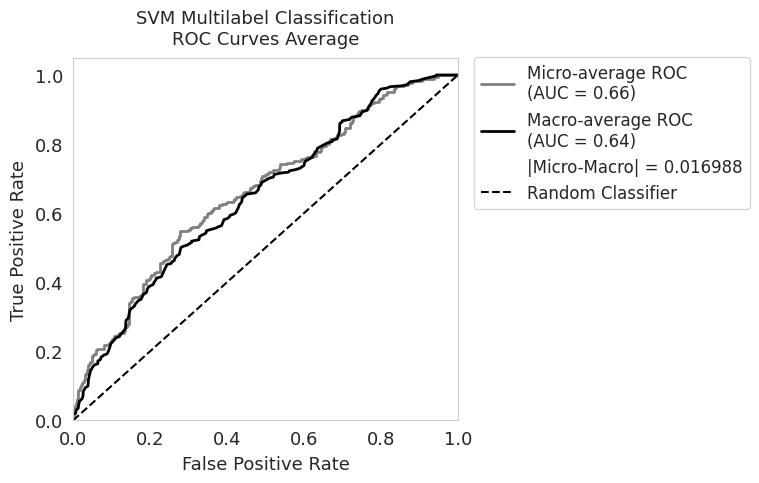

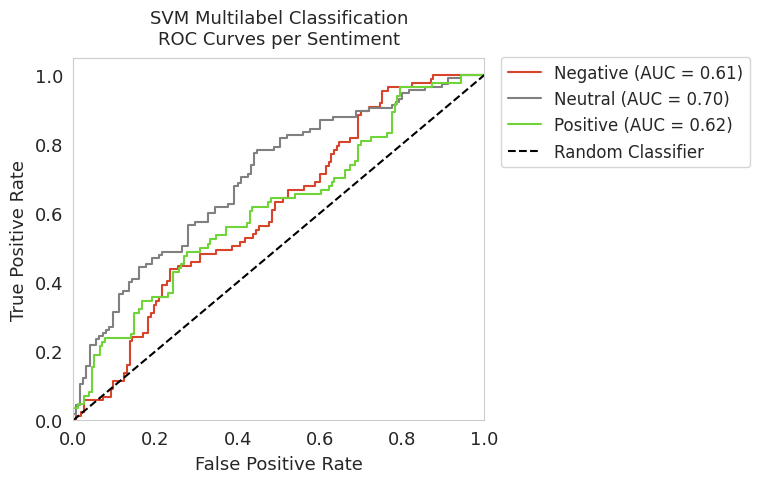

,ROC AUC,Standard Deviation,95% CI Lower,95% CI Upper,Standard Error
Average Type,,,,,
Micro,0.659196,0.042429,0.599229,0.719162,0.030595
Macro,0.642207,0.042429,0.594195,0.690220,0.024496
Weighted,0.648358,0.044145,0.588206,0.708509,0.030689
Micro-Macro Gap,0.016988,-,-,-,-



Note: A small micro-macro AUC gap indicates uniform model performance across sentiment classes.
A large micro-macro AUC gap indicates inconsistent model performance across sentiment classes.


Class,Negative,Neutral,Positive
Total Samples,240.000000,240.000000,240.000000
Positive Samples,87.000000,115.000000,84.000000
Negative Samples,153.000000,125.000000,156.000000
AUC (roc_curve),0.609421,0.702122,0.615079
AUC (roc_auc_score),0.609421,0.702122,0.615079
95% CI Lower,0.601133,0.694646,0.606748
95% CI Upper,0.617709,0.709598,0.623411
Difference between methods,0.000000,0.000000,0.000000
Optimal Threshold,0.262134,0.403732,0.381114
Precision,0.419192,0.616438,0.488095



ROC curve average metrics saved to: /workspace/Output/SVM/SVM_ML/Results/roc_curve_average_metrics.csv

ROC curve analysis saved to: /workspace/Output/SVM/SVM_ML/Results/roc_curve_analysis.csv




In [54]:
#==================================================================================================
#         Visualizations ROC Curve for Multilabel Classification using the model prodictions 
#==================================================================================================

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Seaborn setting
sns.set_style("whitegrid", {'axes.grid': False})

# Base output directory
base_dir = "/workspace/Output/SVM/SVM_ML"
predictions_dir = os.path.join(base_dir, 'Results/predictions')
figure_dir = os.path.join(base_dir, "Figures")
os.makedirs(figure_dir, exist_ok=True)

# Load and prepare data
ensemble_logits = np.load(os.path.join(predictions_dir, 'ensemble_logits.npy'))
y_test_true = np.load(os.path.join(base_dir, 'test_data/y_test_ML.npy'))

# Sigmoid function for converting logits to probabilities
def sigmoid(x):
    """Compute sigmoid values for each set of scores in x."""
    return 1 / (1 + np.exp(-x))

# Convert logits to probabilities
test_pred_proba = sigmoid(ensemble_logits)

# Define labels and colors
label_names = ['Negative', 'Neutral', 'Positive']
colors = ['#d5442b', 'grey', '#6fd437']


# ======================== ROC Curves Plotting ========================
display(HTML('<div style="font-size: 22px; font-weight: bold;">ROC Curves</div>'))

# --------- First plot: Micro and Macro average ROC curves --------- 
plt.figure(figsize=(7.8, 5))

# Compute micro-average ROC curve
y_test_bin = label_binarize(y_test_true, classes=range(len(label_names)))
y_test_flat = y_test_bin.ravel()
y_pred_proba_flat = test_pred_proba.ravel()

# Initialize variables for micro-average ROC
fpr_micro, tpr_micro, roc_auc_micro = 0, 0, 0

# Compute micro-average ROC curve using flattened arrays
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), test_pred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, 
         label=f'Micro-average ROC\n(AUC = {roc_auc_micro:.2f})',
         color='gray', linestyle='-', linewidth=2)

# Compute and plot macro-average ROC curve
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], test_pred_proba[:, i])[0] 
                                  for i in range(len(label_names))]))
mean_tpr = np.zeros_like(all_fpr)

class_aucs = []
for i in range(len(label_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_pred_proba[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
    class_aucs.append(auc(fpr, tpr))

mean_tpr /= len(label_names)
macro_auc = np.mean(class_aucs)

# Calculate micro-macro difference
micro_macro_diff = abs(roc_auc_micro - macro_auc)

plt.plot(all_fpr, mean_tpr, 'k-',
         label=f'Macro-average ROC\n(AUC = {macro_auc:.2f})',
         linewidth=2)

# Add separate legend entry for micro-macro difference
plt.plot([], [], ' ', 
         label=f'|Micro-Macro| = {micro_macro_diff:.6f}')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Multilabel Classification\nROC Curves Average')
plt.legend(bbox_to_anchor=(1.02, 1.025), loc='upper left')
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(figure_dir, 'SVM_ML_ROC_curves_averages.png'), 
            dpi=300, bbox_inches='tight')
plt.show()



# ---------  Second plot: Per-class ROC curves --------- 
plt.figure(figsize=(7.8, 5))

# Store ROC results for reporting
roc_results = []

# Plot ROC curves for each class
for i, (class_name, color) in enumerate(zip(label_names, colors)):
    # One-vs-rest approach
    y_true_binary = y_test_bin[:, i]  # Use the binarized labels directly
    y_score = test_pred_proba[:, i]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Compute confidence interval for AUC
    n_pos = np.sum(y_true_binary)
    n_neg = len(y_true_binary) - n_pos
    se = np.sqrt((roc_auc * (1 - roc_auc)) / (n_pos * n_neg))
    ci_lower = max(0, roc_auc - 1.96 * se)
    ci_upper = min(1, roc_auc + 1.96 * se)
    
    # Store results
    roc_results.append({
        'Class': class_name,
        'AUC': roc_auc,
        'CI Lower': ci_lower,
        'CI Upper': ci_upper
    })
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=color,
             label=f'{class_name} (AUC = {roc_auc:.2f})')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Multilabel Classification\nROC Curves per Sentiment')
plt.legend(bbox_to_anchor=(1.02, 1.025), loc='upper left')
plt.tight_layout()

# Save the figure
sentiment_roc_curve_path = os.path.join(figure_dir, 'SVM_ML_ROC_curves_per_sentiment.png')
plt.savefig(sentiment_roc_curve_path, dpi=300, bbox_inches='tight')
sentiment_roc_curve_path2 = os.path.join(figure_dir, 'SVM_ML_ROC_curves_per_sentiment.tiff')
plt.savefig(sentiment_roc_curve_path2, dpi=300, bbox_inches='tight')

plt.show()



# ======================== Additional Statistics ========================

# ------------------- Calculate ROC Average Metrics ---------------------

def calculate_average_metrics(y_true, y_pred_proba, classes):
    """
    Calculate micro, macro, and weighted averages for ROC AUC scores.
    Also includes standard deviation of AUC scores across classes.
    """
    n_classes = len(classes)
    
    # Binarize the labels for multi-class metrics
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Initialize lists for storing metrics
    class_metrics = []
    class_auc_scores = []
    
    # Calculate metrics for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        class_metrics.append({
            'class': classes[i],
            'auc': roc_auc,
        })
        class_auc_scores.append(roc_auc)
    
    # Micro average
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    
    # Macro average (simple average of class-wise AUC scores)
    auc_macro = np.mean(class_auc_scores)
    
    # Weighted average (weighted by class support)
    class_support = np.sum(y_true_bin, axis=0)
    auc_weighted = np.average(class_auc_scores, weights=class_support)
    
    # Calculate standard errors and confidence intervals
    n_samples = len(y_true)
    
    # Standard error for micro average
    se_micro = np.sqrt(auc_micro * (1 - auc_micro) / n_samples)
    ci_micro = (auc_micro - 1.96 * se_micro, auc_micro + 1.96 * se_micro)
    
    # Standard error for macro average
    se_macro = np.sqrt(np.var(class_auc_scores) / n_classes)
    ci_macro = (auc_macro - 1.96 * se_macro, auc_macro + 1.96 * se_macro)
    
    # Standard error for weighted average
    se_weighted = np.sqrt(np.average([(auc * (1 - auc)) for auc in class_auc_scores], 
                                   weights=class_support) / n_samples)
    ci_weighted = (auc_weighted - 1.96 * se_weighted, auc_weighted + 1.96 * se_weighted)
    
    # Calculate standard deviations
    std_across_classes = np.std(class_auc_scores)
    
    return {
        'micro': {
            'auc': auc_micro,
            'ci': ci_micro,
            'se': se_micro,
            'std': std_across_classes
        },
        'macro': {
            'auc': auc_macro,
            'ci': ci_macro,
            'se': se_macro,
            'std': std_across_classes
        },
        'weighted': {
            'auc': auc_weighted,
            'ci': ci_weighted,
            'se': se_weighted,
            'std': np.sqrt(np.average((np.array(class_auc_scores) - auc_weighted) ** 2, weights=class_support))
        },
        'class_metrics': class_metrics
    }

# Calculate average metrics
average_metrics = calculate_average_metrics(y_test_true, test_pred_proba, range(len(label_names)))

# Create a DataFrame for average metrics
average_metrics_data = []
for avg_type in ['micro', 'macro', 'weighted']:
    metrics = average_metrics[avg_type]
    average_metrics_data.append({
        'Average Type': avg_type.capitalize(),
        'ROC AUC': f"{metrics['auc']:.6f}",
        'Standard Deviation': f"{metrics['std']:.6f}",
        '95% CI Lower': f"{metrics['ci'][0]:.6f}",
        '95% CI Upper': f"{metrics['ci'][1]:.6f}",
        'Standard Error': f"{metrics['se']:.6f}"
    })

# Add the micro-macro gap row
micro_macro_gap = abs(average_metrics['micro']['auc'] - average_metrics['macro']['auc'])
average_metrics_data.append({
    'Average Type': 'Micro-Macro Gap',
    'ROC AUC': f"{micro_macro_gap:.6f}",
    'Standard Deviation': "-",
    '95% CI Lower': "-",
    '95% CI Upper': "-",
    'Standard Error': "-"
})

average_metrics_df = pd.DataFrame(average_metrics_data)
average_metrics_df = average_metrics_df.set_index('Average Type')


# Display the average metrics table
print("\n")
display(HTML('<div style="font-size: 22px; font-weight: bold;">Receiver Operating Characteristic (ROC) Curve Metrics</div>'))
display(HTML("<br><b>Area Under the Curve (AUC): ROC Curve Average Metrics</b>"))
display(HTML(average_metrics_df.to_html()))

# Save average metrics to CSV
average_metrics_save_path = os.path.join(base_dir, 'Results', 'roc_curve_average_metrics.csv')
average_metrics_df.to_csv(average_metrics_save_path, sep=';')

# Notes printing
print("\nNote: A small micro-macro AUC gap indicates uniform model performance across sentiment classes.")
print("A large micro-macro AUC gap indicates inconsistent model performance across sentiment classes.")



# ------------- ROC Curve Detailed Analysis per Sentiments -------------

detailed_roc_results = []
for i, class_name in enumerate(label_names):
    # One-vs-rest approach
    y_true_binary = y_test_bin[:, i]  # Use the binarized labels directly
    y_score = test_pred_proba[:, i]
    
    # Method 1: sklearn's roc_curve
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
    
    # Method 2: Direct AUC computation
    auc_direct = auc(fpr, tpr)
    
    # Method 3: roc_auc_score
    auc_score = roc_auc_score(y_true_binary, y_score)
    
    # Additional statistical validation
    n_pos = np.sum(y_true_binary)
    n_neg = len(y_true_binary) - n_pos
    
    # Confidence interval for AUC
    se = np.sqrt((auc_direct * (1 - auc_direct)) / (n_pos * n_neg))
    ci_lower = max(0, auc_direct - 1.96 * se)
    ci_upper = min(1, auc_direct + 1.96 * se)
    
    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Calculate metrics at optimal threshold
    y_pred_threshold = (y_score >= optimal_threshold).astype(int)
    
    precision = precision_score(y_true_binary, y_pred_threshold, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_threshold, zero_division=0)
    
    # Store results
    result = {
        'Class': class_name,
        'Total Samples': len(y_true_binary),
        'Positive Samples': n_pos,
        'Negative Samples': n_neg,
        'AUC (roc_curve)': auc_direct,
        'AUC (roc_auc_score)': auc_score,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper,
        'Difference between methods': abs(auc_direct - auc_score),
        'Optimal Threshold': optimal_threshold,
        'Precision': precision,
        'Recall': recall
    }
    
    detailed_roc_results.append(result)

# Create a transposed DataFrame for better readability
roc_analysis_df = pd.DataFrame(detailed_roc_results).set_index('Class').T

# format float columns to a specific number of decimal places
float_columns = roc_analysis_df.select_dtypes(include=[np.float64]).columns
for col in float_columns:
    roc_analysis_df[col] = roc_analysis_df[col].apply(lambda x: f"{x:.6f}" if pd.notnull(x) else x)

# Save to CSV
save_path = os.path.join(base_dir, 'Results', 'roc_curve_analysis.csv')
roc_analysis_df.to_csv(save_path, sep=';')

# Display in Jupyter Notebook
display(HTML("<br><b>\nROC Curve Analysis by Sentiment</b>"))
display(HTML(roc_analysis_df.to_html()))
print(f"\nROC curve average metrics saved to: {average_metrics_save_path}")
print(f"\nROC curve analysis saved to: {save_path }\n\n")


### Probability Distribution for Multilabel Classification

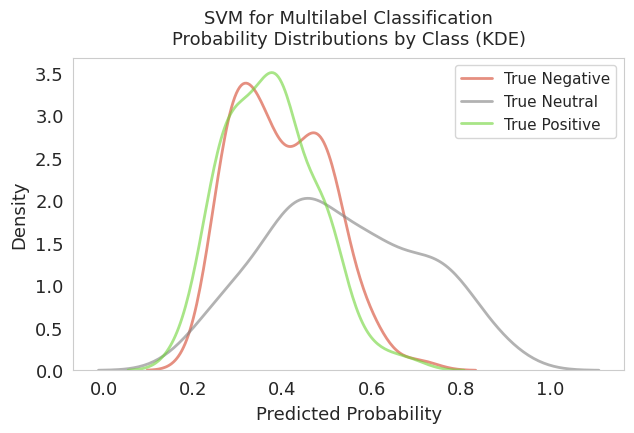

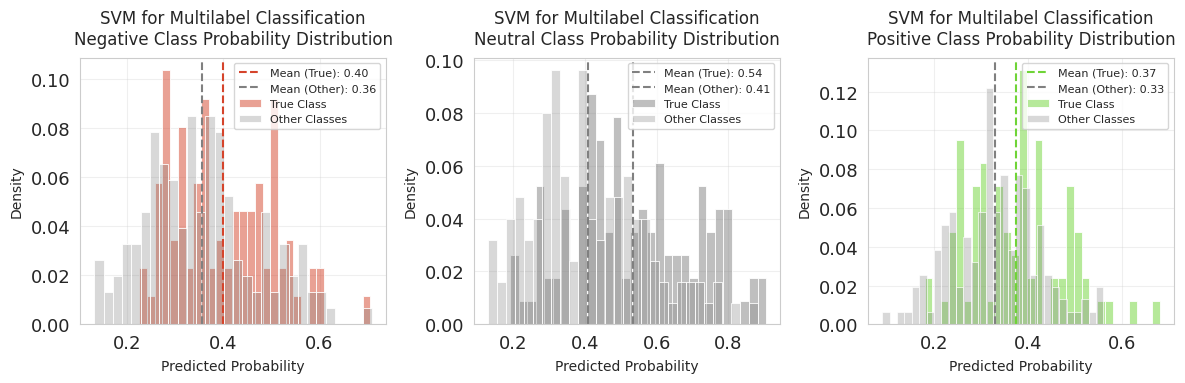

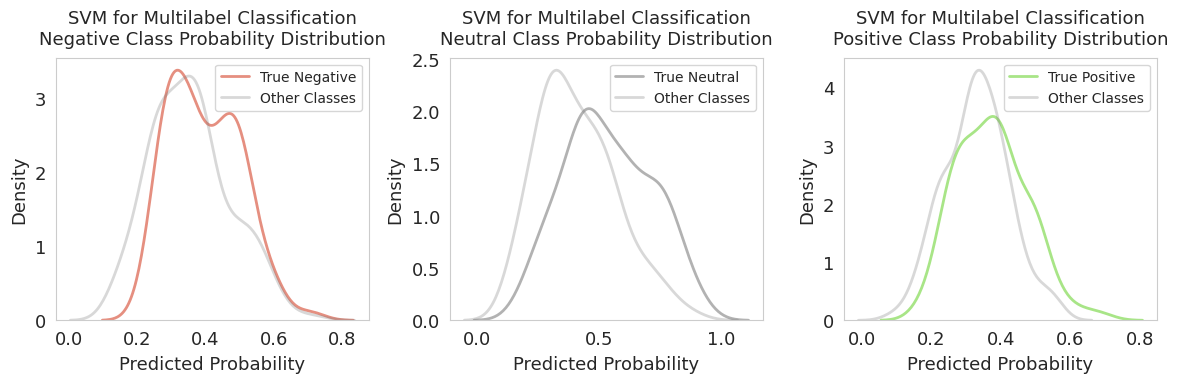

,True Class (Mean),True Class (Std),Other Classes (Mean),Other Classes (Std),Separation
Metric,,,,,
Negative,0.398179,0.103586,0.355031,0.116164,0.043148
Neutral,0.535576,0.175715,0.409220,0.160201,0.126356
Positive,0.373958,0.101271,0.329608,0.092056,0.044350


In [29]:
# ============== Visualize Probability Distributions for Multilabel Classification ====================

# Define labels and colors
label_names = ['Negative', 'Neutral', 'Positive']
colors = ['#d5442b', 'grey', '#6fd437']

# ============== Visualize Probability Distributions for Multilabel Classification ====================

# --------------- KDE Plot All Sentiment ---------------

plt.figure(figsize=(6.5, 4.5))
for i, (class_name, color) in enumerate(zip(label_names, colors)):
    class_probs = test_pred_proba[:, i]
    true_class = y_test_bin[:, i].astype(bool)  # Use the binarized labels directly
    
    # Plot distributions
    sns.kdeplot(data=class_probs[true_class], color=color, alpha=0.6, 
                label=f'True {class_name}', linewidth=2)

plt.title('SVM for Multilabel Classification\nProbability Distributions by Class (KDE)')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend(fontsize=11)
plt.grid(False)
plt.tight_layout()

# Save the figure
prob_path = os.path.join(figure_dir, 'SVM_ML_probability_distributions.png')
plt.savefig(prob_path, dpi=300, bbox_inches='tight')
display(HTML('<div style="font-size: 22px; font-weight: bold;">Probability Distributions</div>'))

plt.show()



# ================== Enhanced Probability Distribution Visualization ===================

plt.figure(figsize=(12, 4))
for i, class_name in enumerate(label_names):
    plt.subplot(1, 3, i+1)
    # Get probabilities for the current class
    class_probs = test_pred_proba[:, i]
    # Get true labels for this class
    true_class = y_test_bin[:, i].astype(bool)
    
    # Plot distributions separately for true positives and true negatives
    sns.histplot(data=class_probs[true_class], bins=30, color=colors[i], alpha=0.5, 
                label='True Class', stat='probability')
    sns.histplot(data=class_probs[~true_class], bins=30, color='gray', alpha=0.3, 
                label='Other Classes', stat='probability')
    
    # Add mean lines
    plt.axvline(class_probs[true_class].mean(), color=colors[i], linestyle='--', 
                label=f'Mean (True): {class_probs[true_class].mean():.2f}')
    plt.axvline(class_probs[~true_class].mean(), color='gray', linestyle='--', 
                label=f'Mean (Other): {class_probs[~true_class].mean():.2f}')
    
    plt.title(f'SVM for Multilabel Classification\n{class_name} Class Probability Distribution', fontsize=12)
    plt.xlabel('Predicted Probability', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
plt.tight_layout()


# Save the figure
roc_curve_path = os.path.join(figure_dir, 'SVM_ML_probability_distributions_hist_true_false.png')
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()



# --------------- KDE Plot - separate plots for each class ---------------
plt.figure(figsize=(12, 4))

for i, (class_name, color) in enumerate(zip(label_names, colors)):
    plt.subplot(1, 3, i+1)
    
    # Get probabilities for current class
    class_probs = test_pred_proba[:, i]
    true_class = y_test_bin[:, i].astype(bool)
    
    # Plot distributions
    sns.kdeplot(data=class_probs[true_class], color=color, alpha=0.6, 
                label=f'True {class_name}', linewidth=2)
    sns.kdeplot(data=class_probs[~true_class], color='gray', alpha=0.3, 
                label=f'Other Classes', linewidth=2)
    
    plt.title(f'SVM for Multilabel Classification\n{class_name} Class Probability Distribution')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend(fontsize=10)
    plt.grid(False)

plt.tight_layout()


# Save the figure
roc_curve_path = os.path.join(figure_dir, 'SVM_ML_probability_distributions_KDE_true_false.png')
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()



# ================== Print distribution statistics ==================
# Create and display probability distribution statistics table
prob_stats = []
metrics = ['True Class (Mean)', 'True Class (Std)', 'Other Classes (Mean)', 
          'Other Classes (Std)', 'Separation']

for i, class_name in enumerate(label_names):
    class_probs = test_pred_proba[:, i]
    true_class = y_test_bin[:, i].astype(bool)
    
    stats = {
        'Metric': class_name,
        'True Class (Mean)': f"{class_probs[true_class].mean():.6f}",
        'True Class (Std)': f"{class_probs[true_class].std():.6f}",
        'Other Classes (Mean)': f"{class_probs[~true_class].mean():.6f}",
        'Other Classes (Std)': f"{class_probs[~true_class].std():.6f}",
        'Separation': f"{class_probs[true_class].mean() - class_probs[~true_class].mean():.6f}"
    }
    prob_stats.append(stats)

# Create DataFrame and display
prob_stats_df = pd.DataFrame(prob_stats).set_index('Metric')
display(HTML("<br><b>Probability Distribution Statistics</b>"))
display(HTML(prob_stats_df.to_html()))

### Confusion Matrices for Multilabel Classification


Sentiment Distribution:


,True Label,Predictions
Negative,87,40
Neutral,115,97
Positive,84,17



Sentiment Distribution table saved in: /workspace/Output/SVM/SVM_ML/Results SVM_ML_Sentiment_Distribution.csv

Classification Report:


,precision,recall,f1-score,support
Negative,0.475000,0.218391,0.299213,87.0
Neutral,0.639175,0.539130,0.584906,115.0
Positive,0.588235,0.119048,0.198020,84.0
micro avg,0.590909,0.318182,0.413636,286.0
macro avg,0.567470,0.292190,0.360713,286.0
weighted avg,0.574272,0.318182,0.384368,286.0
samples avg,0.358333,0.320139,0.327083,286.0



Additional Statistical Metrics:


,Metric,Value
0,Weighted Accuracy,0.640632
1,Weighted Precision,0.574272
2,Weighted Recall,0.318182
3,Weighted F1-Score,0.384368
4,Hamming Loss,0.358333



Analysis complete. Results saved in: /workspace/Output/SVM/SVM_ML/Results


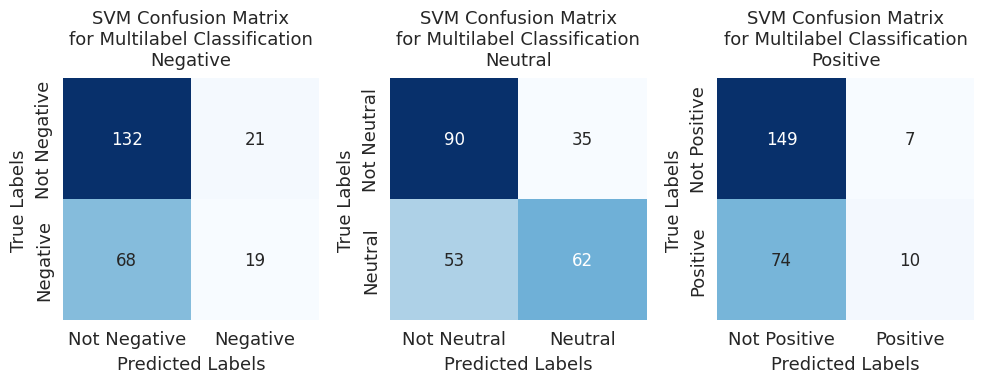

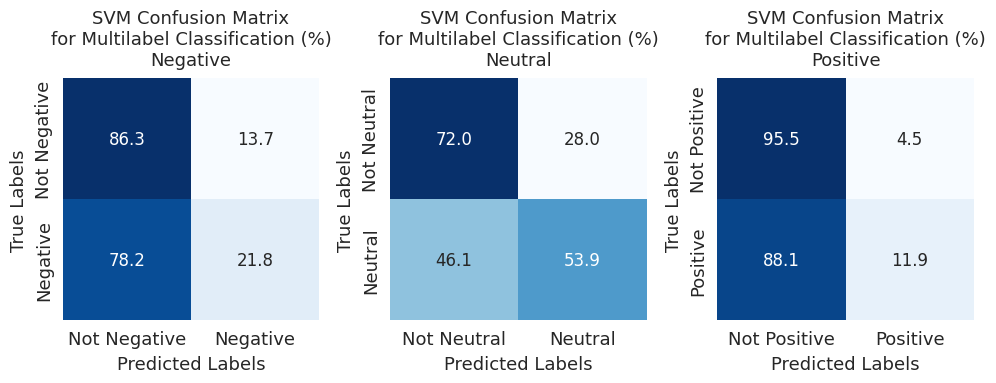

In [53]:
#==================================================================================================
#                 Visualizations of Confusion Matrices and Sentiment Distribution 
#==================================================================================================


# ============== Preparing Data ================
# Using the data from ROC curve analysis
# Convert numeric predictions to string labels
y_true_str = [label_names[i] for i in np.argmax(y_test_bin, axis=1)]
y_pred = np.argmax(test_pred_proba, axis=1)
y_pred_str = [label_names[i] for i in y_pred]

# Create output directory if it doesn't exist
output_dir = os.path.join(base_dir, 'Results')
os.makedirs(output_dir, exist_ok=True)

def compute_statistical_metrics(y_true, y_pred, labels):
    """Compute additional statistical metrics"""
    # Create copies of input data
    y_true_copy = np.array(y_true).copy()
    y_pred_copy = np.array(y_pred).copy()
    
    label_map = {label: idx for idx, label in enumerate(labels)}
    y_true_numeric = np.array([label_map[label] for label in y_true_copy])
    y_pred_numeric = np.array([label_map[label] for label in y_pred_copy])
    
    results = {
        'Weighted Accuracy': accuracy_score(y_true_numeric, y_pred_numeric, normalize=True),
        'Weighted Precision': precision_score(y_true_numeric, y_pred_numeric, average='weighted'),
        'Weighted Recall': recall_score(y_true_numeric, y_pred_numeric, average='weighted'),
        'Weighted F1-Score': f1_score(y_true_numeric, y_pred_numeric, average='weighted'),
        'Cohen\'s Kappa': cohen_kappa_score(y_true_numeric, y_pred_numeric)        
    }
    
    return results.copy()

# ============== Basic Distribution Analysis ================
# Create DataFrames for True Label and Prediction distributions
true_label_dist = pd.DataFrame({label: y_test_bin[:, i].sum() for i, label in enumerate(label_names)}, index=['True Label']).T
prediction_dist = pd.DataFrame({label: (test_pred_proba[:, i] >= 0.5).sum() for i, label in enumerate(label_names)}, index=['Predictions']).T

# Merge the two DataFrames
distribution_table = pd.concat([true_label_dist, prediction_dist], axis=1)

# Reorder rows to match the desired order
distribution_table = distribution_table.loc[label_names]

# Convert counts to integers
distribution_table = distribution_table.astype(int)

print("\nSentiment Distribution:")
display(distribution_table)

# Save the distribution table
distribution_table.to_csv(os.path.join(output_dir, 'SVM_ML_Sentiment_Distribution.csv'))
print("\nSentiment Distribution table saved in:", output_dir, 'SVM_ML_Sentiment_Distribution.csv')

# Calculate accuracy for each class
accuracies = [(y_test_bin[:, i] == (test_pred_proba[:, i] >= 0.5)).mean() for i in range(len(label_names))]

# Classification report
print("\nClassification Report:")
class_report = classification_report(y_test_bin, (test_pred_proba >= 0.5).astype(int), target_names=label_names, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
display(class_report_df)

# Additional metrics
additional_metrics = {
    'Weighted Accuracy': np.average(accuracies, weights=[len(y_test_bin[y_test_bin[:, i] == 1]) for i in range(len(label_names))]),
    'Weighted Precision': class_report['weighted avg']['precision'],
    'Weighted Recall': class_report['weighted avg']['recall'],
    'Weighted F1-Score': class_report['weighted avg']['f1-score'],
    'Hamming Loss': hamming_loss(y_test_bin, (test_pred_proba >= 0.5).astype(int))
}

print("\nAdditional Statistical Metrics:")
additional_metrics_df = pd.DataFrame.from_dict(additional_metrics, orient='index', columns=['Value'])
additional_metrics_df.index.name = 'Metric'
additional_metrics_df = additional_metrics_df.reset_index()
additional_metrics_df['Value'] = additional_metrics_df['Value'].apply(lambda x: f'{x:.6f}')
pd.set_option('display.max_colwidth', None)
display(additional_metrics_df)

print("\nAnalysis complete. Results saved in:", output_dir)


# ============== Confusion Matrix Visualization ================

# Create confusion matrices for each class
confusion_matrices = []
for i, class_name in enumerate(label_names):
    y_true_binary = y_test_bin[:, i]
    y_pred_binary = (test_pred_proba[:, i] >= 0.5).astype(int)
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    confusion_matrices.append(cm)

# Plot counts
fig_counts, axes_counts = plt.subplots(1, len(confusion_matrices), figsize=(10, 4))
axes_counts = [axes_counts] if len(confusion_matrices) == 1 else axes_counts

for i, conf_matrix in enumerate(confusion_matrices):
    sns.heatmap(
        conf_matrix,
        annot=conf_matrix,
        fmt='g',
        cmap='Blues',
        cbar=False,
        ax=axes_counts[i],
        xticklabels=[f'Not {label_names[i]}', label_names[i]],
        yticklabels=[f'Not {label_names[i]}', label_names[i]]
    )
    axes_counts[i].set_title(f'SVM Confusion Matrix\nfor Multilabel Classification\n{label_names[i]}')
    axes_counts[i].set_xlabel('Predicted Labels')
    axes_counts[i].set_ylabel('True Labels')

plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'SVM_ML_confusion_matrix_counts.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot percentages
fig_percentages, axes_percentages = plt.subplots(1, len(confusion_matrices), figsize=(10, 4))
axes_percentages = [axes_percentages] if len(confusion_matrices) == 1 else axes_percentages

for i, conf_matrix in enumerate(confusion_matrices):
    row_sums = conf_matrix.sum(axis=1)
    conf_matrix_normalized = np.zeros_like(conf_matrix, dtype=float)
    for j in range(len(row_sums)):
        if row_sums[j] != 0:
            conf_matrix_normalized[j] = conf_matrix[j] / row_sums[j]
    
    sns.heatmap(
        conf_matrix_normalized * 100,
        annot=np.round(conf_matrix_normalized * 100, 1),
        fmt='.1f',
        cmap='Blues',
        cbar=False,
        ax=axes_percentages[i],
        xticklabels=[f'Not {label_names[i]}', label_names[i]],
        yticklabels=[f'Not {label_names[i]}', label_names[i]]
    )
    axes_percentages[i].set_title(f'SVM Confusion Matrix\nfor Multilabel Classification (%)\n{label_names[i]}')
    axes_percentages[i].set_xlabel('Predicted Labels')
    axes_percentages[i].set_ylabel('True Labels')

plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'SVM_ML_confusion_matrix_percentage.png'), 
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, 'SVM_ML_confusion_matrix_percentage.tiff'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Multilabel VS multiclass comparison

## Comparing Hyperparameters

In [31]:
# ========== Print a comparative table with both hyperparameters ============

import os
import json
import pandas as pd
from IPython.display import display, HTML

# File paths
MC_PARAMS_PATH = "/workspace/Output/SVM/SVM_MC/Optuna_search/SVM_multiclass_optuna_best_params_4_balanced.json"
ML_PARAMS_PATH = "/workspace/Output/SVM/SVM_ML/Optuna_search/SVM_multilabel_optuna_best_params.json"

def read_json_params(file_path):
    """Read parameters from JSON file"""
    try:
        with open(file_path, 'r') as f:
            params = json.load(f)
            return params
    except FileNotFoundError:
        print(f"Warning: {file_path} not found")
        return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON file {file_path}: {e}")
        return {}

def create_parameter_comparison():
    """Create and save parameter comparison table"""
    # Get parameters from JSON files
    mc_params = read_json_params(MC_PARAMS_PATH)
    ml_params = read_json_params(ML_PARAMS_PATH)
    
    # Define base parameters that don't change
    base_params = {
        "Max iter": "3000",
        "Decision Function": "ovr",
        "Tol": "0.01",
        "Verbose": "False",
        "Cross-Validation Folds": "5",
        "Number of Labels": "3",
        "Seed": "42",
        "Hyperparameter Search Method": "Optuna"
    }
    
    # Create DataFrame content
    data = {
        "Parameters": [
            "Ngram Range",
            "Max Features",
            "C",
            "Kernel",
            "Gamma",
            "Degree",
            "Loss Function",
            *base_params.keys()
        ],
        "Multiclass SVM": [
            str(mc_params.get('tfidf__ngram_range', 'N/A')),
            str(mc_params.get('tfidf__max_features', 'N/A')),
            str(mc_params.get('svm__C', 'N/A')),
            str(mc_params.get('svm__kernel', 'N/A')),
            str(mc_params.get('svm__gamma', 'N/A')),
            str(mc_params.get('svm__degree', 'N/A')),
            "Hinge Loss",
            *base_params.values()
        ],
        "Multilabel SVM": [
            str(ml_params.get('tfidf__ngram_range', 'N/A')),
            str(ml_params.get('tfidf__max_features', 'N/A')),
            str(ml_params.get('svm__C', 'N/A')),
            str(ml_params.get('svm__kernel', 'N/A')),
            str(ml_params.get('svm__gamma', 'N/A')),
            str(ml_params.get('svm__degree', 'N/A')),
            "Binary Relevance Loss",
            *base_params.values()
        ]
    }
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Save to CSV
    output_dir = '/workspace/Output/SVM/Comparison'
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "SVM_parameters_comparison.csv")
    df.to_csv(output_file, index=False, sep=';')
    print(f"\nSaved comparison table to: {output_file}")
    
    return df

# Create and display the table
comparison_df = create_parameter_comparison()
display(HTML(comparison_df.to_html(index=False)))



Saved comparison table to: /workspace/Output/SVM/Comparison/SVM_parameters_comparison.csv


Parameters,Multiclass SVM,Multilabel SVM
Ngram Range,"[1, 2]","[1, 3]"
Max Features,3500,3000
C,1,100
Kernel,rbf,linear
Gamma,scale,auto
Degree,5,5
Loss Function,Hinge Loss,Binary Relevance Loss
Max iter,3000,3000
Decision Function,ovr,ovr
Tol,0.01,0.01


## Comparating Metrics

### Accuracy, Precision, Recall and F1-Score Comparison

In [32]:
# Table including multiclass and mutlilabel results

try:
   # Define file paths and read CSV files
   mc_file_path = '/workspace/Output/SVM/SVM_MC/Results/test_result_complete.csv'
   ml_file_path = '/workspace/Output/SVM/SVM_ML/Results/test_result_complete.csv'
   
   mc_results = pd.read_csv(mc_file_path, sep=';', encoding='utf-8')
   ml_results = pd.read_csv(ml_file_path, sep=';', encoding='utf-8')
   
   # Define metric mappings
   metric_pairs = [
       ("Accuracy", "Accuracy (Macro)", "Accuracy (Weighted)"),
       ("Precision", "Precision (Macro)", "Precision (Weighted)"),
       ("Recall", "Recall (Macro)", "Recall (Weighted)"),
       ("F1-Score", "F1-Score (Macro)", "F1-Score (Weighted)")
   ]

   comparative_data = []
   
   # Process each metric pair
   for base_metric, mc_metric, ml_metric in metric_pairs:
       try:
           # Get MC values (using Macro)
           mc_row = mc_results[mc_results['Metric'] == mc_metric]
           if not mc_row.empty:
               mc_row = mc_row.iloc[0]
               mc_value = float(mc_row['Ensemble Score'])
               mc_std = float(mc_row['Individual Std'])
               mc_ci_lower = float(mc_row['CI Lower'])
               mc_ci_upper = float(mc_row['CI Upper'])
           else:
               print(f"Warning: Metric {mc_metric} not found in MC data")
               continue
           
           # Get ML values (using Weighted)
           ml_row = ml_results[ml_results['Metric'] == ml_metric]
           if not ml_row.empty:
               ml_row = ml_row.iloc[0]
               ml_value = float(ml_row['Ensemble Score'])
               ml_std = float(ml_row['Individual Std'])
               ml_ci_lower = float(ml_row['CI Lower'])
               ml_ci_upper = float(ml_row['CI Upper'])
           else:
               print(f"Warning: Metric {ml_metric} not found in ML data")
               continue
           
           difference = ml_value - mc_value
           best_class = "Multilabel" if difference > 0 else "Multiclass"
           
           comparative_data.append({
               'Metric': base_metric,
               'Multiclass SVM *': f"{mc_value:.6f}",
               'Standard deviation MC [Confidence Interval] *': f"{mc_std:.6f} [{mc_ci_lower:.6f}-{mc_ci_upper:.6f}]",
               'Multilabel SVM **': f"{ml_value:.6f}",
               'Standard deviation ML [Confidence Interval] **': f"{ml_std:.6f} [{ml_ci_lower:.6f}-{ml_ci_upper:.6f}]",
               'Difference': f"{difference:.6f}",
               'Best Classification': best_class
           })
           
       except Exception as e:
           print(f"Error processing metric {base_metric}: {str(e)}")
           continue

   # Create DataFrame
   comparative_metrics = pd.DataFrame(comparative_data)

   # Save to CSV
   output_dir = '/workspace/Output/SVM/Comparison'
   os.makedirs(output_dir, exist_ok=True)
   output_file = os.path.join(output_dir, "SVM_comparative_test_results.csv")
   comparative_metrics.to_csv(output_file, index=False, sep=';')

   # Display the table
   display(HTML(comparative_metrics.to_html(index=False)))

   # Print annotations
   display(HTML('<p><i>MC = Multiclass classification ; ML = Multilabel classification</i></p>'))
   display(HTML('<p><i>* Macro results (treats all classes equally)</i></p>'))
   display(HTML('<p><i>** Weighted results (account for class imbalance)</i></p>'))
   

except Exception as e:
   print(f"Main error: {str(e)}")

Metric,Multiclass SVM *,Standard deviation MC [Confidence Interval] *,Multilabel SVM **,Standard deviation ML [Confidence Interval] **,Difference,Best Classification
Accuracy,0.495833,0.045776 [0.416645-0.543739],0.631944,0.019865 [0.578916-0.634071],0.136111,Multilabel
Precision,0.499289,0.056549 [0.405620-0.562624],0.539203,0.029652 [0.452911-0.535237],0.039914,Multilabel
Recall,0.494244,0.046223 [0.413111-0.541446],0.493007,0.030848 [0.415811-0.501459],-0.001237,Multiclass
F1-Score,0.493896,0.049617 [0.403010-0.540768],0.515006,0.030563 [0.431284-0.516139],0.021109,Multilabel


### Accuracy, Metric2, Precision, Recall and F1-Score Comparison

In [33]:
# Version 2: table including multiclass and mutlilabel results including Metric2

import pandas as pd
from IPython.display import HTML
import os

try:
   # Define file paths and read CSV files
   mc_file_path = '/workspace/Output/SVM/SVM_MC/Results/test_result_complete.csv'
   ml_file_path = '/workspace/Output/SVM/SVM_ML/Results/test_result_complete.csv'
   
   mc_results = pd.read_csv(mc_file_path, sep=';', encoding='utf-8')
   ml_results = pd.read_csv(ml_file_path, sep=';', encoding='utf-8')
   
   # Define metric mappings
   metric_pairs = [
       ("Accuracy", "Accuracy (Macro)", "Accuracy (Weighted)"),
       ("Metric2", "Metric2_MC", "Metric2"),  # Added Metric2
       ("Precision", "Precision (Macro)", "Precision (Weighted)"),
       ("Recall", "Recall (Macro)", "Recall (Weighted)"),
       ("F1-Score", "F1-Score (Macro)", "F1-Score (Weighted)")
   ]

   comparative_data = []
   
   # Process each metric pair
   for base_metric, mc_metric, ml_metric in metric_pairs:
       try:
           # Get MC values (using Macro)
           mc_row = mc_results[mc_results['Metric'] == mc_metric]
           if not mc_row.empty:
               mc_row = mc_row.iloc[0]
               mc_value = float(mc_row['Ensemble Score'])
               mc_std = float(mc_row['Individual Std'])
               mc_ci_lower = float(mc_row['CI Lower'])
               mc_ci_upper = float(mc_row['CI Upper'])
           else:
               print(f"Warning: Metric {mc_metric} not found in MC data")
               continue
           
           # Get ML values (using Weighted)
           ml_row = ml_results[ml_results['Metric'] == ml_metric]
           if not ml_row.empty:
               ml_row = ml_row.iloc[0]
               ml_value = float(ml_row['Ensemble Score'])
               ml_std = float(ml_row['Individual Std'])
               ml_ci_lower = float(ml_row['CI Lower'])
               ml_ci_upper = float(ml_row['CI Upper'])
           else:
               print(f"Warning: Metric {ml_metric} not found in ML data")
               continue
           
           difference = ml_value - mc_value
           best_class = "Multilabel" if difference > 0 else "Multiclass"
           
           comparative_data.append({
               'Metric': base_metric,
               'Multiclass SVM *': f"{mc_value:.6f}",
               'Standard deviation MC [Confidence Interval] *': f"{mc_std:.6f} [{mc_ci_lower:.6f}-{mc_ci_upper:.6f}]",
               'Multilabel SVM **': f"{ml_value:.6f}",
               'Standard deviation ML [Confidence Interval] **': f"{ml_std:.6f} [{ml_ci_lower:.6f}-{ml_ci_upper:.6f}]",
               'Difference': f"{difference:.6f}",
               'Best Classification': best_class
           })
           
       except Exception as e:
           print(f"Error processing metric {base_metric}: {str(e)}")
           continue

   # Create DataFrame
   comparative_metrics = pd.DataFrame(comparative_data)

   # Save to CSV
   output_dir = '/workspace/Output/SVM/Comparison'
   os.makedirs(output_dir, exist_ok=True)
   output_file = os.path.join(output_dir, "SVM_comparative_test_results_with metric2.csv")
   comparative_metrics.to_csv(output_file, index=False, sep=';')

   # Display the table
   display(HTML(comparative_metrics.to_html(index=False)))

   # Print annotations
   display(HTML('<p><i>MC = Multiclass classification ; ML = Multilabel classification</i></p>'))
   display(HTML('<p><i>* Macro results (treats all classes equally)</i></p>'))
   display(HTML('<p><i>** Weighted results (account for class imbalance)</i></p>'))

except Exception as e:
   print(f"Main error: {str(e)}")

Metric,Multiclass SVM *,Standard deviation MC [Confidence Interval] *,Multilabel SVM **,Standard deviation ML [Confidence Interval] **,Difference,Best Classification
Accuracy,0.495833,0.045776 [0.416645-0.543739],0.631944,0.019865 [0.578916-0.634071],0.136111,Multilabel
Metric2,0.458595,0.006068 [0.436486-0.453334],0.475000,0.028338 [0.439718-0.518397],0.016405,Multilabel
Precision,0.499289,0.056549 [0.405620-0.562624],0.539203,0.029652 [0.452911-0.535237],0.039914,Multilabel
Recall,0.494244,0.046223 [0.413111-0.541446],0.493007,0.030848 [0.415811-0.501459],-0.001237,Multiclass
F1-Score,0.493896,0.049617 [0.403010-0.540768],0.515006,0.030563 [0.431284-0.516139],0.021109,Multilabel


### Comparing Area Under the Curve (AUC) ROC Scores

In [34]:
# Building a comparative AUC table

try:
    # Define file paths
    mc_file_path = '/workspace/Output/SVM/SVM_MC/Results/roc_curve_average_metrics.csv'
    ml_file_path = '/workspace/Output/SVM/SVM_ML/Results/roc_curve_average_metrics.csv'
    
    # Read CSV files
    mc_results = pd.read_csv(mc_file_path, sep=';', encoding='utf-8')
    ml_results = pd.read_csv(ml_file_path, sep=';', encoding='utf-8')
    
    # Define AUC metrics to compare
    auc_metrics = [
        ("AUC (Macro)", "macro", "macro"),
        ("AUC (Micro)", "micro", "micro")
    ]

    comparative_data = []
    
    # Process each AUC metric
    for base_metric, mc_metric, ml_metric in auc_metrics:
        try:
            # Get MC values
            mc_row = mc_results[mc_results['Average Type'].str.lower() == mc_metric]
            if not mc_row.empty:
                mc_row = mc_row.iloc[0]
                mc_value = float(mc_row['ROC AUC'])
                mc_std = float(mc_row['Standard Deviation'])
                mc_ci_lower = float(mc_row['95% CI Lower'])
                mc_ci_upper = float(mc_row['95% CI Upper'])
            else:
                print(f"Warning: Metric {mc_metric} not found in MC data")
                continue
            
            # Get ML values
            ml_row = ml_results[ml_results['Average Type'].str.lower() == ml_metric]
            if not ml_row.empty:
                ml_row = ml_row.iloc[0]
                ml_value = float(ml_row['ROC AUC'])
                ml_std = float(ml_row['Standard Deviation'])
                ml_ci_lower = float(ml_row['95% CI Lower'])
                ml_ci_upper = float(ml_row['95% CI Upper'])
            else:
                print(f"Warning: Metric {ml_metric} not found in ML data")
                continue
            
            difference = ml_value - mc_value
            best_class = "Multilabel" if difference > 0 else "Multiclass"
            
            comparative_data.append({
                'Metric': base_metric,
                'Multiclass SVM': f"{mc_value:.6f}",
                'Standard deviation MC [Confidence Interval]': f"{mc_std:.6f} [{mc_ci_lower:.6f}-{mc_ci_upper:.6f}]",
                'Multilabel SVM': f"{ml_value:.6f}",
                'Standard deviation ML [Confidence Interval]': f"{ml_std:.6f} [{ml_ci_lower:.6f}-{ml_ci_upper:.6f}]",
                'Difference': f"{difference:.6f}",
                'Best Classification': best_class
            })
            
        except Exception as e:
            print(f"Error processing metric {base_metric}: {str(e)}")
            continue

    # Create DataFrame
    comparative_metrics = pd.DataFrame(comparative_data)

    # Save to CSV
    output_dir = '/workspace/Output/SVM/Comparison'
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "SVM_comparative_roc_results.csv")
    comparative_metrics.to_csv(output_file, index=False, sep=';')

    # Display the table
    display(HTML(comparative_metrics.to_html(index=False)))

    # Print annotations
    display(HTML('<p><i>MC = Multiclass classification ; ML = Multilabel classification</i></p>'))

except Exception as e:
    print(f"Main error: {str(e)}")

Metric,Multiclass SVM,Standard deviation MC [Confidence Interval],Multilabel SVM,Standard deviation ML [Confidence Interval],Difference,Best Classification
AUC (Macro),0.674407,0.026132 [0.644835-0.703978],0.642207,0.042429 [0.594195-0.690220],-0.032200,Multiclass
AUC (Micro),0.678967,0.026132 [0.619899-0.738035],0.659196,0.042429 [0.599229-0.719162],-0.019771,Multiclass


## ROC (Receiver Operating Characteristic) Curves Comparisons

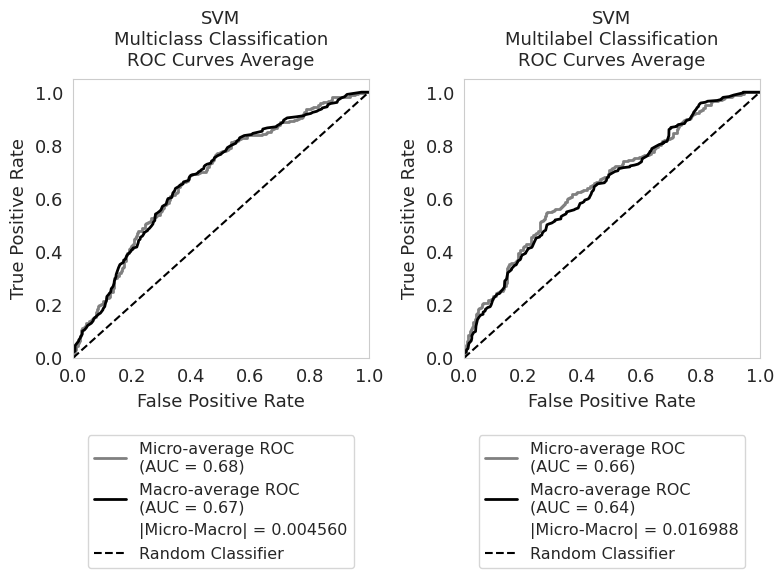

In [57]:
# ====================== Comparative ROC Curves ============================

# Create figure with 1 row and 2 columns
plt.figure(figsize=(8, 6.5))

# Seaborn setting
sns.set_style("whitegrid", {'axes.grid': False})

# ======================== First Subplot (Multiclass) ========================
plt.subplot(1, 2, 1)

# Base output directory
base_dir = "/workspace/Output/SVM/SVM_MC"
predictions_dir = os.path.join(base_dir, 'Results/predictions')
figure_dir = os.path.join(base_dir, "Figures")
os.makedirs(figure_dir, exist_ok=True)

# Load and prepare data
ensemble_logits = np.load(os.path.join(predictions_dir, 'ensemble_logits.npy'))
y_test_true = np.load(os.path.join(base_dir, 'test_data/y_test.npy'))

# Softmax function for converting logits to probabilities
def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Convert logits to probabilities
test_pred_proba = softmax(ensemble_logits)

# Define labels and colors
label_names = ['Negative', 'Neutral', 'Positive']
colors = ['#d5442b', 'grey', '#6fd437']

# Compute micro-average ROC curve
y_test_bin = label_binarize(y_test_true, classes=range(len(label_names)))
y_test_flat = y_test_bin.ravel()
y_pred_proba_flat = test_pred_proba.ravel()
fpr_micro, tpr_micro, _ = roc_curve(y_test_flat, y_pred_proba_flat)
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, 
         label=f'Micro-average ROC\n(AUC = {roc_auc_micro:.2f})',
         color='gray', linestyle='-', linewidth=2)

# Compute and plot macro-average ROC curve
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], test_pred_proba[:, i])[0] 
                                  for i in range(len(label_names))]))
mean_tpr = np.zeros_like(all_fpr)
class_aucs = []
for i in range(len(label_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_pred_proba[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
    class_aucs.append(auc(fpr, tpr))
mean_tpr /= len(label_names)
macro_auc = np.mean(class_aucs)

# Calculate micro-macro difference
micro_macro_diff = abs(roc_auc_micro - macro_auc)
plt.plot(all_fpr, mean_tpr, 'k-',
         label=f'Macro-average ROC\n(AUC = {macro_auc:.2f})',
         linewidth=2)

# Add separate legend entry for micro-macro difference
plt.plot([], [], ' ', 
         label=f'|Micro-Macro| = {micro_macro_diff:.6f}')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM\nMulticlass Classification\nROC Curves Average')
plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', fontsize=11.5)

# ======================== Second Subplot (Multilabel) ========================
plt.subplot(1, 2, 2)

# Base output directory
base_dir = "/workspace/Output/SVM/SVM_ML"
predictions_dir = os.path.join(base_dir, 'Results/predictions')
figure_dir = os.path.join(base_dir, "Figures")
os.makedirs(figure_dir, exist_ok=True)

# Load and prepare data
ensemble_logits = np.load(os.path.join(predictions_dir, 'ensemble_logits.npy'))
y_test_true = np.load(os.path.join(base_dir, 'test_data/y_test_ML.npy'))

# Sigmoid function for converting logits to probabilities
def sigmoid(x):
    """Compute sigmoid values for each set of scores in x."""
    return 1 / (1 + np.exp(-x))

# Convert logits to probabilities
test_pred_proba = sigmoid(ensemble_logits)

# Compute micro-average ROC curve
y_test_bin = label_binarize(y_test_true, classes=range(len(label_names)))
y_test_flat = y_test_bin.ravel()
y_pred_proba_flat = test_pred_proba.ravel()

# Initialize variables for micro-average ROC
fpr_micro, tpr_micro, roc_auc_micro = 0, 0, 0

# Compute micro-average ROC curve using flattened arrays
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), test_pred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, 
         label=f'Micro-average ROC\n(AUC = {roc_auc_micro:.2f})',
         color='gray', linestyle='-', linewidth=2)

# Compute and plot macro-average ROC curve
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], test_pred_proba[:, i])[0] 
                                  for i in range(len(label_names))]))
mean_tpr = np.zeros_like(all_fpr)
class_aucs = []
for i in range(len(label_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_pred_proba[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
    class_aucs.append(auc(fpr, tpr))
mean_tpr /= len(label_names)
macro_auc = np.mean(class_aucs)

# Calculate micro-macro difference
micro_macro_diff = abs(roc_auc_micro - macro_auc)
plt.plot(all_fpr, mean_tpr, 'k-',
         label=f'Macro-average ROC\n(AUC = {macro_auc:.2f})',
         linewidth=2)

# Add separate legend entry for micro-macro difference
plt.plot([], [], ' ', 
         label=f'|Micro-Macro| = {micro_macro_diff:.6f}')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM\nMultilabel Classification\nROC Curves Average')
plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', fontsize=11.5)

# Create output directory if it doesn't exist
output_dir = '/workspace/Output/SVM/Comparison'
os.makedirs(output_dir, exist_ok=True)

# Adjust layout and save
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'SVM_combined_ROC_curves.png'), 
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, 'SVM_combined_ROC_curves.tiff'), 
            dpi=300, bbox_inches='tight')
plt.show()

## Comparing Probability Distribution Plot

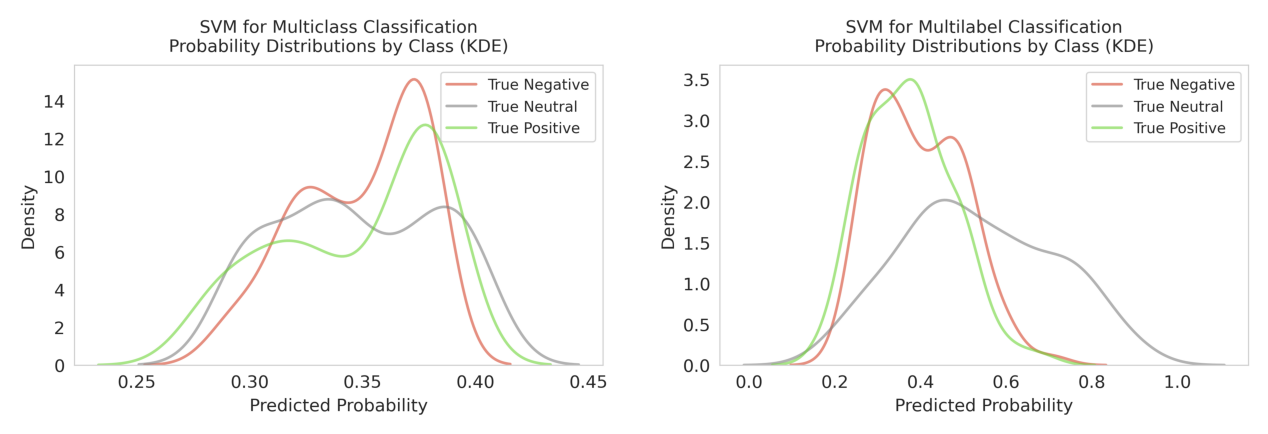

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the paths to the existing plots
mc_plot_path = '/workspace/Output/SVM/SVM_MC/Figures/SVM_MC_probability_distributions.png'
ml_plot_path = '/workspace/Output/SVM/SVM_ML/Figures/SVM_ML_probability_distributions.png'

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))

# Read and display the first plot (Multiclass)
img1 = mpimg.imread(mc_plot_path)
ax1.imshow(img1)
ax1.axis('off')  # Turn off axis for cleaner look

# Read and display the second plot (Multilabel)
img2 = mpimg.imread(ml_plot_path)
ax2.imshow(img2)
ax2.axis('off')  # Turn off axis for cleaner look

plt.tight_layout()

# Create output directory if it doesn't exist
output_dir = '/workspace/Output/SVM/Comparison'
os.makedirs(output_dir, exist_ok=True)

# Save the combined figure
combined_path = os.path.join(output_dir, 'SVM_combined_probability_distributions.png')
plt.savefig(combined_path, dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, 'SVM_combined_probability_distributions.tiff'), 
            dpi=300, bbox_inches='tight')

plt.show()